# Prior knowledge preparation and utilizing

## Acquisition of textual content.

### Table 1

In [14]:
import pandas as pd
import numpy as np
from scipy import stats

# 计算95% CI和std
def calculate_stats(data):
    confidence = 0.95
    n = len(data)
    mean = np.mean(data)
    std = np.std(data)
    std_err = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, mean, std_err)
    return round(mean, 3), round(std, 3), round(ci[0], 3), round(ci[1], 3)

# 对数值列计算统计量
df = pd.read_csv(r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\comparison_results_processed.csv')
numeric_columns = df.select_dtypes(include=[np.number]).columns
stats_results = {}

for col in numeric_columns:
    mean, std, ci_lower, ci_upper = calculate_stats(df[col].dropna())
    stats_results[col] = {
        'mean': mean,
        'std': std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# 转换结果为DataFrame
stats_df = pd.DataFrame(stats_results).T
print("\nStatistical Summary:")
print(stats_df.head(5))


Statistical Summary:
              mean    std  ci_lower  ci_upper
Being-away   0.393  0.231     0.373     0.412
Coherence    0.461  0.214     0.443     0.479
Scope        0.455  0.207     0.438     0.472
Fascination  0.445  0.211     0.428     0.463
Average      0.439  0.127     0.428     0.449


In [ ]:
import base64
import json
from openai import OpenAI
import time
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from threading import Semaphore

# 创建信号量限制并发请求
MAX_CONCURRENT_REQUESTS = 10  # 可以根据API限制调整这个值
semaphore = Semaphore(MAX_CONCURRENT_REQUESTS)

def vlm_evaluate(image_path):
    try:
        # 使用信号量控制并发
        with semaphore:
            with open(image_path, 'rb') as image_file:
                image_data = image_file.read()
                base64_image = base64.b64encode(image_data).decode('utf-8')
            
            client = OpenAI(
                api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx",
                base_url = "https://api.zetatechs.com/v1/",
            )

            response = client.chat.completions.create(
                model='gpt-4o',
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", 
                             "text": "Please describe this street view image (limited 100words)."
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                },
                            },
                        ],
                    }
                ],
            )

            response_text = response.choices[0].message.content.strip()
            return image_path, response_text
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return image_path, "Failed to get image description"

def process_single_image(row, idx, total):
    image = 'D:/A_Research/A_doing_research/20250804_LLM_campus_restoration/shanghai/test//' + row['image']
    print(f"Processing image {idx + 1}/{total}: {row['image']}")
    
    image_path, image_description = vlm_evaluate(image)
    
    text = f"This image taken in Shenzhen. {image_description} The restorative indicator scores are:\n" \
           f"- Being-away: {row['Being-away']:.5f}\n" \
           f"- Coherence: {row['Coherence']:.5f}\n" \
           f"- Scope: {row['Scope']:.5f}\n" \
           f"- Fascination: {row['Fascination']:.5f}\n" \
           f"- Average Score: {row['Average']:.5f}"
    
    return {'image_path': image, 'text': text}

def create_image_text_pairs(data):
    pairs = []
    total = len(data)
    
    # 创建线程池
    with ThreadPoolExecutor(max_workers=MAX_CONCURRENT_REQUESTS) as executor:
        # 提交所有任务
        future_to_row = {
            executor.submit(process_single_image, row, idx, total): idx 
            for idx, row in data.iterrows()
        }
        
        # 使用tqdm创建进度条
        with tqdm(total=total) as pbar:
            for future in as_completed(future_to_row):
                pair = future.result()
                pairs.append(pair)
                pbar.update(1)
    
    return pd.DataFrame(pairs)

# 读取CSV文件
df = pd.read_csv(r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\comparison_results_processed.csv')

# 获取图像文本对并转换为DataFrame
image_text_df = create_image_text_pairs(df)

# 保存到CSV文件
image_text_df.to_csv('image_text_pairs_sz.csv', index=False)

print("Image-text pairs have been saved to image_text_pairs.csv")

In [31]:
import pandas as pd

def create_image_text_pairs(data):
    pairs = []
    
    for _, row in data.iterrows():
        image = '.\\image\\' + row['image']
        
        text = f"This is an image could taken in {row['Time']}. The restorative indicator scores are:\n" \
               f"- Being-away: {row['Being-away']:.5f}\n" \
               f"- Coherence: {row['Coherence']:.5f}\n" \
               f"- Scope: {row['Scope']:.5f}\n" \
               f"- Fascination: {row['Fascination']:.5f}\n" \
               f"- Average Score: {row['Average']:.5f}"
        
        pairs.append({'image_path': image, 'text': text})
    
    return pd.DataFrame(pairs)

# Create DataFrame
df = pd.read_csv(r'D:\A_Research\C_complete_research\√20240522_seasonchange+SVI+campus\test_samples_all.csv')

# Get image-text pairs and convert to DataFrame
image_text_df = create_image_text_pairs(df)

# Save to CSV file
image_text_df.to_csv('image_text_pairs2.csv', index=False)

print("Image-text pairs have been saved to image_text_pairs.csv")

Image-text pairs have been saved to image_text_pairs.csv


## Multimodal embedding and retrieval. 

In [4]:
import torch
from PIL import Image
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import os
from tqdm import tqdm

# 读取CSV文件
df = pd.read_csv('image_text_pairs_sz.csv')

# 加载CLIP模型和处理器
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_image(image_path):
    try:
        image = Image.open(image_path)
        inputs = processor(images=image, return_tensors="pt", padding=True)
        image_features = model.get_image_features(**inputs)
        return image_features.detach().numpy()
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def encode_text(text):
    try:
        inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77)
        text_features = model.get_text_features(**inputs)
        return text_features.detach().numpy()
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# 存储编码结果的字典
embeddings = {
    'image_embeddings': [],
    'text_embeddings': [],
    'image_paths': [],
    'texts': []
}

# 处理每一行数据
for idx, row in tqdm(df.iterrows()):
    image_path = row['image_path']
    text = row['text']
    
    # 编码图片
    img_embedding = encode_image(image_path)
    if img_embedding is not None:
        embeddings['image_embeddings'].append(img_embedding)
        embeddings['image_paths'].append(image_path)
    
    # 编码文本
    text_embedding = encode_text(text)
    if text_embedding is not None:
        embeddings['text_embeddings'].append(text_embedding)
        embeddings['texts'].append(text)

# 将编码结果转换为numpy数组并保存
embeddings['image_embeddings'] = np.array(embeddings['image_embeddings'])
embeddings['text_embeddings'] = np.array(embeddings['text_embeddings'])

# 保存编码结果
np.save('clip_embeddings_sz.npy', embeddings)

print("Embeddings have been saved successfully!")

d:\miniconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
566it [03:11,  2.96it/s]

Embeddings have been saved successfully!


In [61]:
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from typing import List, Tuple
import os

class CLIPRetriever:
    def __init__(self, embeddings_path: str):
        # 加载CLIP模型和处理器
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        # 加载存储的embeddings
        self.stored_data = np.load(embeddings_path, allow_pickle=True).item()
        
        # 将存储的embeddings转换为张量
        self.image_embeddings = torch.tensor(self.stored_data['image_embeddings'].squeeze())
        self.texts = self.stored_data['texts']

    def encode_query_image(self, image_path: str) -> torch.Tensor:
        """编码查询图片"""
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        image_features = self.model.get_image_features(**inputs)
        return image_features.detach()

    def compute_similarity(self, query_embedding: torch.Tensor) -> torch.Tensor:
        """计算余弦相似度"""
        # 标准化embeddings
        query_embedding = query_embedding.squeeze()
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        image_embeddings = self.image_embeddings / self.image_embeddings.norm(dim=-1, keepdim=True)
        
        # 计算相似度
        similarity = torch.matmul(query_embedding, image_embeddings.T)
        return similarity

    def retrieve(self, query_image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
        """检索最相似的文本"""
        # 编码查询图片
        query_embedding = self.encode_query_image(query_image_path)
        
        # 计算相似度
        similarities = self.compute_similarity(query_embedding)
        
        # 获取top-k结果
        top_k_values, top_k_indices = torch.topk(similarities, min(top_k, len(self.texts)))
        
        # 返回结果
        results = []
        for score, idx in zip(top_k_values.tolist(), top_k_indices.tolist()):
            results.append((self.texts[idx], score))
        
        return results

# 使用示例
def main():
    # 初始化检索器
    retriever = CLIPRetriever('clip_embeddings3.npy')
    
    # 查询图片路径
    query_image_path = "201708_120.2643098_31.48716696.png"
    
    # 获取检索结果
    results = retriever.retrieve(query_image_path, top_k=3)
    
    # 打印结果
    print(f"\nQuery Image: {query_image_path}")
    print("\nRetrieved Texts:")
    for text, score in results:
        print(f"\nSimilarity Score: {score:.4f}")
        print(f"Text: {text}")

if __name__ == "__main__":
    main()


Query Image: 201708_120.2643098_31.48716696.png

Retrieved Texts:

Similarity Score: 0.9093
Text: This image could taken in Summer. The image shows a peaceful street lined with lush green trees on both sides, creating a serene atmosphere. The road forks into two paths, with a landscaped garden in the center featuring trimmed bushes, grass, and decorative stone steps. A few cars are visible parked along the curved road on the right. Surrounding buildings with modern facades are partially visible, suggesting an institutional or corporate campus setting. Overcast skies add a soft light to the scene, enhancing the greenery's vividness. The view captures a clean, well-maintained environment designed for both aesthetics and functionality. The restorative indicator scores are:
- Being-away: 0.46437
- Coherence: 0.62569
- Scope: 0.32641
- Fascination: 0.16312
- Average Score: 0.39490

Similarity Score: 0.9072
Text: This image could taken in Summer. This street view shows a peaceful, tree-line

### Figure 3

d:\miniconda3\envs\torch\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\miniconda3\envs\torch\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\miniconda3\envs\torch\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


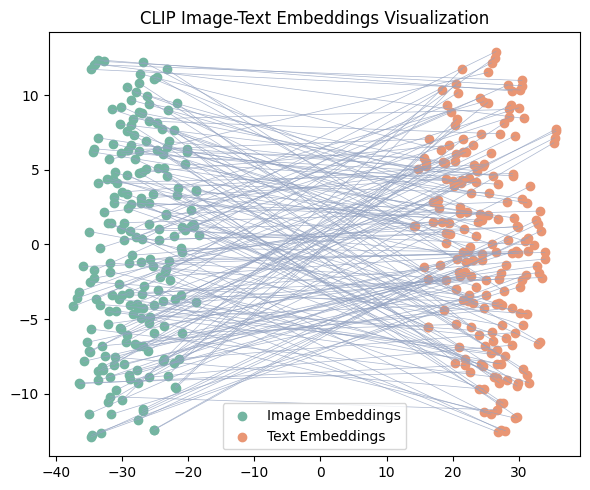

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 加载保存的embeddings
embeddings = np.load('clip_embeddings.npy', allow_pickle=True).item()

# 提取embeddings并reshape
image_embeddings = np.vstack([emb.reshape(1, -1) for emb in embeddings['image_embeddings']])
text_embeddings = np.vstack([emb.reshape(1, -1) for emb in embeddings['text_embeddings']])

# 合并图像和文本embeddings
combined_embeddings = np.vstack([image_embeddings, text_embeddings])

# 首先使用PCA降至50维
pca = PCA(n_components=50)
combined_embeddings_pca = pca.fit_transform(combined_embeddings)

# 然后使用t-SNE降至2维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_embeddings_tsne = tsne.fit_transform(combined_embeddings_pca)

# 分离图像和文本的降维结果
n_images = len(image_embeddings)
image_tsne = combined_embeddings_tsne[:n_images]
text_tsne = combined_embeddings_tsne[n_images:]

# 创建可视化
plt.figure(figsize=(6, 5))

# 绘制散点图
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], 
           alpha=1, c='#74B5A1', label='Image Embeddings')
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], 
           alpha=1, c='#E99674', label='Text Embeddings')

# 添加一些配对示例（前10对）
for i in range(len(image_tsne)):
    plt.plot([image_tsne[i, 0], text_tsne[i, 0]], 
             [image_tsne[i, 1], text_tsne[i, 1]], 
             '#94A3C2', alpha=0.8, linewidth=0.5)

plt.title('CLIP Image-Text Embeddings Visualization')
plt.legend()

plt.tight_layout()
plt.savefig('./figure/clip.jpg', dpi=300)
plt.show()

# Comparison of model performance and methods

## Table 2

In [ ]:
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from typing import List, Tuple
import os
import base64
import json
from openai import OpenAI
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

class CLIPRetriever:
    def __init__(self, embeddings_path: str):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.stored_data = np.load(embeddings_path, allow_pickle=True).item()
        self.image_embeddings = torch.tensor(self.stored_data['image_embeddings'].squeeze())
        self.texts = self.stored_data['texts']

    def encode_query_image(self, image_path: str) -> torch.Tensor:
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        image_features = self.model.get_image_features(**inputs)
        return image_features.detach()

    def compute_similarity(self, query_embedding: torch.Tensor) -> torch.Tensor:
        query_embedding = query_embedding.squeeze()
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        image_embeddings = self.image_embeddings / self.image_embeddings.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(query_embedding, image_embeddings.T)
        return similarity

    def retrieve(self, query_image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
        query_embedding = self.encode_query_image(query_image_path)
        similarities = self.compute_similarity(query_embedding)
        top_k_values, top_k_indices = torch.topk(similarities, min(top_k, len(self.texts)))
        results = []
        for score, idx in zip(top_k_values.tolist(), top_k_indices.tolist()):
            results.append((self.texts[idx], score))
        return results

class BatchImageEvaluator:
    def __init__(self, api_key: str, base_url: str, embeddings_path: str, max_workers: int = 4):
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.retriever = CLIPRetriever(embeddings_path)
        self.max_workers = max_workers
        
    def process_single_image(self, image_path: str, message_template: str) -> dict:
        try:
            # Retrieve similar images
            results = self.retriever.retrieve(image_path, top_k=2)
            formatted_message = message_template.format(RAG="\n".join([text for text, score in results]))
            
            # Read and encode image
            with open(image_path, 'rb') as image_file:
                base64_image = base64.b64encode(image_file.read()).decode('utf-8')
            
            # Make API call
            response = self.client.chat.completions.create(
                model='gemini-2.5-flash-lite-preview-06-17-nothinking',
                # model='zeta/claude3-7-sonnet-20250219',
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": formatted_message},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }]
            )
            
            response_text = response.choices[0].message.content.strip()
            
            # Parse response
            if response_text.startswith('```') and response_text.endswith('```'):
                response_text = response_text.strip('`')
            response_text = response_text.lstrip('json\n')
            result = json.loads(response_text)
            
            return {
                "image_path": image_path,
                "result": result,
                "status": "success"
            }
            
        except Exception as e:
            return {
                "image_path": image_path,
                "result": {"score": 0.0, "reason": str(e)},
                "status": "error"
            }

    def evaluate_batch(self, image_paths: List[str], message_template: str) -> List[dict]:
        results = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_image = {
                executor.submit(self.process_single_image, image_path, message_template): image_path 
                for image_path in image_paths
            }
            
            for future in tqdm(as_completed(future_to_image), total=len(image_paths)):
                result = future.result()
                results.append(result)
                
        return results

def save_results_to_csv(results: List[dict], output_path: str):
    """将结果保存到CSV文件"""
    data = []
    for result in results:
        row = {
            'image_path': result['image_path'],
            'status': result['status'],
            'score': result['result']['score']
        }
        # 添加每个维度的解释
        if 'reason' in result['result']:
            reason = result['result']['reason']
            if isinstance(reason, dict):
                for dimension, explanation in reason.items():
                    row[f'reason_{dimension}'] = explanation
            else:
                row['reason'] = reason  # 如果reason是字符串，直接保存
        data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

def evaluate_metrics(predictions: List[dict], ground_truth_df: pd.DataFrame):
    """
    计算预测结果与ground truth之间的MSE、RMSE和R2分数
    
    Args:
        predictions: VLM输出的预测结果列表
        ground_truth_df: 包含真实值的DataFrame
    
    Returns:
        dict: 包含MSE、RMSE和R2分数的字典
    """
    # 提取预测值和真实值
    y_pred = []
    y_true = []
    
    for pred in predictions:
        image_path = pred['image_path']
        # 获取对应的ground truth行
        gt_row = ground_truth_df[ground_truth_df['image'] == image_path]
        
        if not gt_row.empty:
            y_pred.append(pred['result']['score'])
            y_true.append(gt_row['Average'].iloc[0])
    
    # 转换为numpy数组
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # 计算指标
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    
    # 计算R2分数
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

if __name__ == "__main__":
    # 配置参数
    api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    base_url = "https://api.zetatechs.com/v1/"

    embeddings_path = "clip_embeddings_sz.npy"
    
    # 读取包含图片路径的CSV文件
    df = pd.read_csv('./shanghai/comparison_results_processed.csv')  # 替换为你的CSV文件路径
    # image_paths = df['image'].tolist()  # 假设列名为'image_path'
    sample_size = int(len(df) * 0.2)
    sampled_df = df.sample(n=sample_size, random_state=42)  # random_state可以保证结果可重复
    image_paths = sampled_df['image'].tolist()  # 假设列名为'image'
    
    # 初始化评估器
    evaluator = BatchImageEvaluator(api_key, base_url, embeddings_path)
    
    # 定义消息模板
    message_template = '''
    You are a university student participating in a campus environment assessment. Carefully analyze the provided image to evaluate psychological restoration quality. Provide step-by-step reasoning before final scoring.

    Evaluate the space using Perceived Restorativeness Scale (PRS)-11 (0-1 scale) across four dimensions. **1 = Strongly agree, 0 = Strongly disagree**. Base all judgments strictly on image features and prior knowledge 

    Prior Knowledge:\n{RAG}.

    Evaluation Dimensions:
    1. Fascination
    - Places like that are fascinating
    - In places like this my attention is drawn to many interesting things
    - In places like this it is hard to be bored
    2. Being Away
    - Places like that are a refuge fom nuisances
    - To get away from things that usually demand my attention I like to go to places like this 
    - To stop thinking about the things that I must get done I like to go to places like this
    3. Coherence
    - There is a clear order in the physical arrangement of places like this
    - In places like this it is easy to see how things are organised
    - In places like this everything seems to have its proper place
    4. Scope
    - That place is large enough to allow exploration in many directions
    - In places like that there are few boundaries to limit my possibility for moving about

    Please provide follow information ONLY:
    1. Average score of all dimension (Scale 0-1 with 5 decimal places)
    2. Explanation for each PRS dimension (limited to 200 words)

    You MUST output JSON format ONLY:
    ```json
    {{
       "score": 0.75, 
       "reason": {{
          "fascination": XXX,
          "being_away": XXX,
          "coherence": XXX,
          "scope": XXX,
       }}
    }}
    '''
    
    # 处理图片批次
    results = evaluator.evaluate_batch(image_paths, message_template)
    
    # 保存结果到CSV
    save_results_to_csv(results, './shanghai/evaluation_results_vlm.csv')

    # 计算评估指标
    metrics = evaluate_metrics(results, df)
    print("\nValidation Metrics:")
    print(f"MSE: {metrics['MSE']:.5f}")
    print(f"RMSE: {metrics['RMSE']:.5f}")
    print(f"R2: {metrics['R2']:.5f}")
    
    # # 打印结果
    # for result in results:
    #     print(f"\nImage: {result['image_path']}")
    #     print(f"Status: {result['status']}")
    #     print(f"Score: {result['result']['score']}")
    #     print("Reasons:")
    #     for dimension, explanation in result['result']['reason'].items():
    #         print(f"- {dimension}: {explanation[:100]}...")

d:\miniconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 113/113 [02:24<00:00,  1.28s/it]

Results saved to ./shanghai/evaluation_results_vlm.csv

Validation Metrics:
MSE: 0.00278
RMSE: 0.05269
R2: 0.82297


### without evaluation

In [ ]:
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from typing import List, Tuple
import os
import base64
import json
from openai import OpenAI
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import pandas as pd

class CLIPRetriever:
    def __init__(self, embeddings_path: str):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.stored_data = np.load(embeddings_path, allow_pickle=True).item()
        self.image_embeddings = torch.tensor(self.stored_data['image_embeddings'].squeeze())
        self.texts = self.stored_data['texts']

    def encode_query_image(self, image_path: str) -> torch.Tensor:
        image = Image.open(image_path)
        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        image_features = self.model.get_image_features(**inputs)
        return image_features.detach()

    def compute_similarity(self, query_embedding: torch.Tensor) -> torch.Tensor:
        query_embedding = query_embedding.squeeze()
        query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)
        image_embeddings = self.image_embeddings / self.image_embeddings.norm(dim=-1, keepdim=True)
        similarity = torch.matmul(query_embedding, image_embeddings.T)
        return similarity

    def retrieve(self, query_image_path: str, top_k: int = 5) -> List[Tuple[str, float]]:
        query_embedding = self.encode_query_image(query_image_path)
        similarities = self.compute_similarity(query_embedding)
        top_k_values, top_k_indices = torch.topk(similarities, min(top_k, len(self.texts)))
        results = []
        for score, idx in zip(top_k_values.tolist(), top_k_indices.tolist()):
            results.append((self.texts[idx], score))
        return results

class BatchImageEvaluator:
    def __init__(self, api_key: str, base_url: str, embeddings_path: str, max_workers: int = 10, 
                 checkpoint_path: str = "checkpoint.json", save_interval: int = 10):
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.retriever = CLIPRetriever(embeddings_path)
        self.max_workers = max_workers
        self.checkpoint_path = checkpoint_path
        self.save_interval = save_interval
        
    def process_single_image(self, image_path: str, message_template: str, max_retries: int = 3) -> dict:
        for attempt in range(max_retries):
            try:
                results = self.retriever.retrieve(image_path, top_k=2)
                formatted_message = message_template.format(RAG="\n".join([text for text, score in results]))
                
                with open(image_path, 'rb') as image_file:
                    base64_image = base64.b64encode(image_file.read()).decode('utf-8')
                
                response = self.client.chat.completions.create(
                    model='gemini-2.5-flash-lite-preview-06-17-nothinking',
                    messages=[{
                        "role": "user",
                        "content": [
                            {"type": "text", "text": formatted_message},
                            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                        ]
                    }]
                )
                
                response_text = response.choices[0].message.content.strip()
                
                # 改进的响应解析
                if response_text.startswith('```') and response_text.endswith('```'):
                    response_text = response_text.strip('`')
                if response_text.startswith('json'):
                    response_text = response_text[4:]
                response_text = response_text.strip()
                result = json.loads(response_text)
                
                return {
                    "image_path": image_path,
                    "result": result,
                    "status": "success"
                }
                
            except Exception as e:
                if attempt == max_retries - 1:
                    return {
                        "image_path": image_path,
                        "result": {"score": 0.0, "reason": str(e)},
                        "status": "error"
                    }
                time.sleep(2 ** attempt)  # 指数退避
                
    def save_checkpoint(self, completed_results: List[dict], remaining_paths: List[str]):
        checkpoint = {
            "completed_results": completed_results,
            "remaining_paths": remaining_paths
        }
        with open(self.checkpoint_path, 'w') as f:
            json.dump(checkpoint, f)
            
    def load_checkpoint(self) -> Tuple[List[dict], List[str]]:
        if os.path.exists(self.checkpoint_path):
            with open(self.checkpoint_path, 'r') as f:
                checkpoint = json.load(f)
                return checkpoint["completed_results"], checkpoint["remaining_paths"]
        return [], []

    def evaluate_batch(self, image_paths: List[str], message_template: str) -> List[dict]:
        completed_results, remaining_paths = self.load_checkpoint()
        
        if not remaining_paths:
            remaining_paths = [p for p in image_paths if not any(r["image_path"] == p for r in completed_results)]
            
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_image = {
                executor.submit(self.process_single_image, image_path, message_template): image_path 
                for image_path in remaining_paths
            }
            
            try:
                for i, future in enumerate(tqdm(as_completed(future_to_image), total=len(remaining_paths))):
                    result = future.result()
                    completed_results.append(result)
                    
                    # 定期保存检查点
                    if (i + 1) % self.save_interval == 0:
                        remaining = [p for p in remaining_paths if not any(r["image_path"] == p for r in completed_results)]
                        self.save_checkpoint(completed_results, remaining)
                        
            except KeyboardInterrupt:
                print("\nProcessing interrupted. Saving checkpoint...")
                remaining = [p for p in remaining_paths if not any(r["image_path"] == p for r in completed_results)]
                self.save_checkpoint(completed_results, remaining)
                raise
                
        return completed_results

def save_results_to_csv(results: List[dict], output_path: str):
    """将结果保存到CSV文件"""
    data = []
    for result in results:
        row = {
            'image_path': result['image_path'],
            'status': result['status'],
            'score': result['result']['score']
        }
        
        # 修复reason处理逻辑
        if 'reason' in result['result']:
            reason = result['result']['reason']
            if isinstance(reason, dict):
                for dimension, explanation in reason.items():
                    row[f'reason_{dimension}'] = explanation
            else:
                row['reason'] = reason  # 如果reason是字符串，直接保存
        data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

if __name__ == "__main__":
    # 配置参数
    api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    base_url = "https://api.zetatechs.com/v1/"

    embeddings_path = "clip_embeddings_sz.npy"
    
    # 读取包含图片路径的CSV文件
    df = pd.read_csv(r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\image_paths.csv')  #你的CSV文件路径
    image_paths = df['full_path'].tolist()  # 假设列名为'image_path'
    
    # 初始化评估器
    evaluator = BatchImageEvaluator(
        api_key=api_key,
        base_url=base_url,
        embeddings_path=embeddings_path,
        checkpoint_path="./result_data/evaluation_checkpoint.json",
        save_interval=10
    )
    
    # 定义消息模板
    message_template = '''
    You are a university student participating in a campus environment assessment. Carefully analyze the provided image to evaluate psychological restoration quality. Provide step-by-step reasoning before final scoring.

    Evaluate the space using Perceived Restorativeness Scale (PRS)-11 (0-1 scale) across four dimensions. **1 = Strongly agree, 0 = Strongly disagree**. Base all judgments strictly on image features and prior knowledge 

    Prior Knowledge:\n{RAG}.

    Evaluation Dimensions:
    1. Fascination
    - Places like that are fascinating
    - In places like this my attention is drawn to many interesting things
    - In places like this it is hard to be bored
    2. Being Away
    - Places like that are a refuge fom nuisances
    - To get away from things that usually demand my attention I like to go to places like this 
    - To stop thinking about the things that I must get done I like to go to places like this
    3. Coherence
    - There is a clear order in the physical arrangement of places like this
    - In places like this it is easy to see how things are organised
    - In places like this everything seems to have its proper place
    4. Scope
    - That place is large enough to allow exploration in many directions
    - In places like that there are few boundaries to limit my possibility for moving about

    Please provide follow information ONLY:
    1. Average score of all dimension (Scale 0-1 with 5 decimal places)
    2. Explanation for each PRS dimension (limited to 200 words)

    You MUST output JSON format ONLY:
    ```json
    {{
       "score": 0.75, 
       "reason": {{
          "fascination": XXX,
          "being_away": XXX,
          "coherence": XXX,
          "scope": XXX,
       }}
    }}
    '''
    
    # 处理图片批次
    try:
        results = evaluator.evaluate_batch(image_paths, message_template)
        save_results_to_csv(results, r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\evaluation_result.csv')
    except KeyboardInterrupt:
        print("\nProcessing interrupted and checkpoint saved. You can resume later.")

d:\miniconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 2575/2575 [19:31<00:00,  2.20it/s] 

Results saved to D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\evaluation_result.csv


## Figure 8

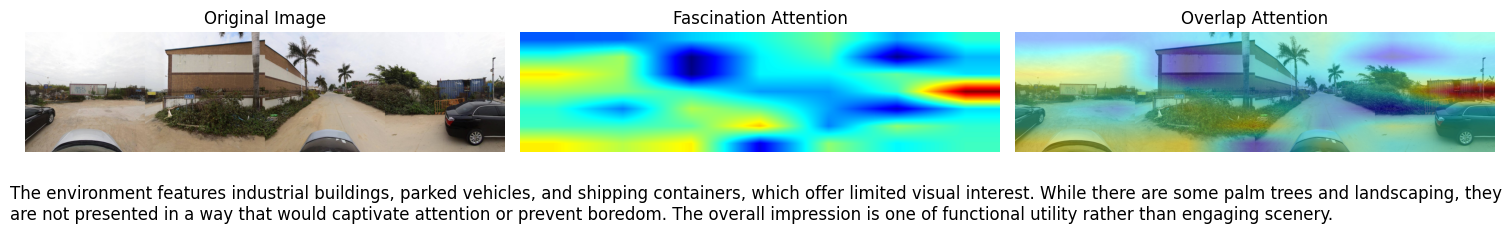

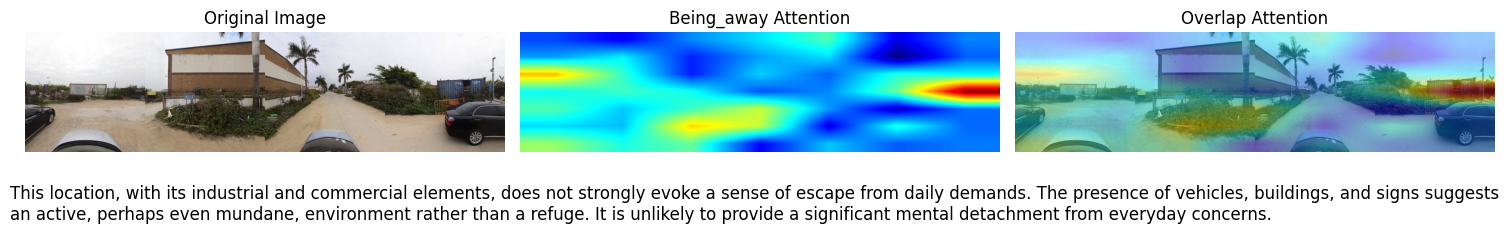

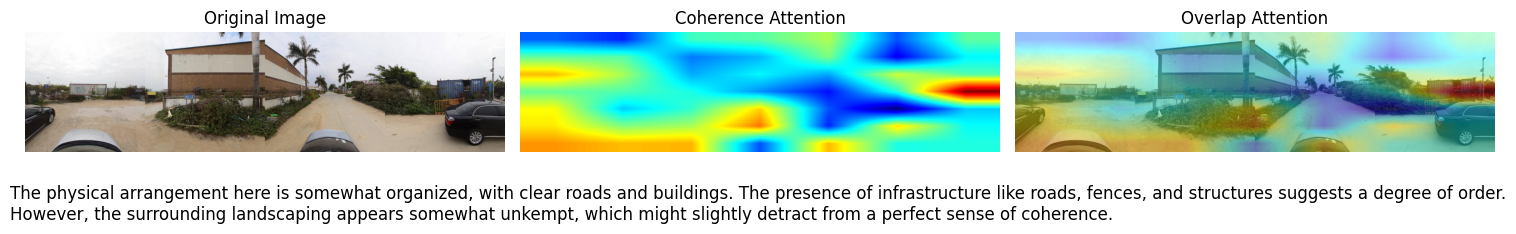

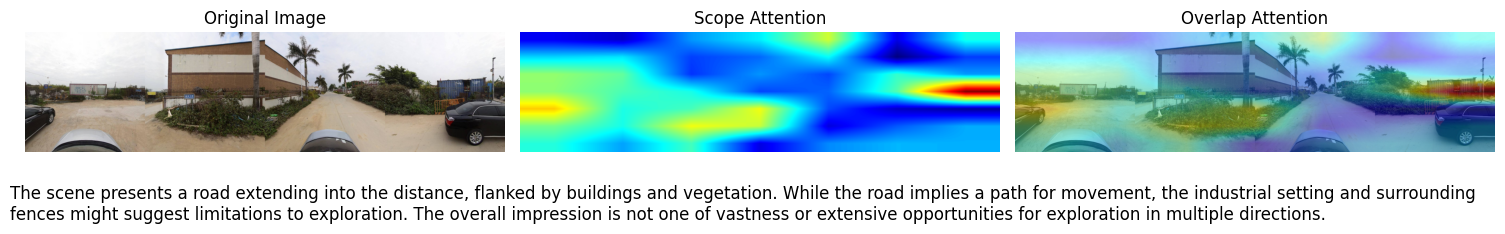

In [68]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import torch.nn.functional as F

class VLMAttentionVisualizer:
    def __init__(self):
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.model.eval()
        
    def extract_key_elements(self, reason_text):
        """从VLM的评价文本中提取关键要素"""
        # 移除标点符号,转为小写
        text = reason_text.lower().replace('.', ' ').replace(',', ' ')
        words = text.split()
        
        # 预定义各维度关注的关键词
        attention_keywords = {
            'fascination': ['tree'],
            'being_away': ['refuge', 'escape', 'away', 'distance', 'separate'],
            'coherence': ['organization', 'order', 'arrangement', 'layout', 'predictable'],
            'scope': ['wide', 'exploration', 'boundaries', 'space', 'broad']
        }
        
        # 提取匹配的关键词
        matched_keywords = []
        for word in words:
            for key_word in attention_keywords.get(self.current_dimension, []):
                if key_word in word:
                    matched_keywords.append(word)
                    
        if not matched_keywords:  # 如果没有匹配的关键词，使用整个文本
            matched_keywords = [text]
            
        return matched_keywords
    
    def generate_attention_map(self, image_path, dimension, reason_text):
        """基于文本评价生成注意力图"""
        self.current_dimension = dimension
        image = Image.open(image_path)
        
        # 处理图像
        image_inputs = self.processor(images=image, return_tensors="pt")
        
        # 获取图像特征
        with torch.no_grad():
            # 获取视觉特征
            vision_outputs = self.model.vision_model(**image_inputs)
            image_features = vision_outputs.last_hidden_state[0, 1:]  # 移除CLS token
            
            # 通过视觉投影层
            image_features = self.model.visual_projection(image_features)
        
        # 从文本中提取关键要素
        key_elements = self.extract_key_elements(reason_text)
        
        # 处理文本
        text_inputs = self.tokenizer(key_elements, padding=True, truncation=True, return_tensors="pt")
        
        with torch.no_grad():
            # 获取文本特征
            text_outputs = self.model.text_model(**text_inputs)
            text_features = text_outputs.last_hidden_state
            
            # 通过文本投影层
            text_features = self.model.text_projection(text_features)
        
        # 计算注意力权重
        attention_weights = torch.zeros(image_features.shape[0])
        
        for i in range(text_features.shape[1]):
            text_feat = text_features[0, i]
            # 计算图像特征与文本特征的相似度
            similarity = F.cosine_similarity(image_features, text_feat.unsqueeze(0), dim=-1)
            attention_weights += similarity
        
        attention_weights = F.softmax(attention_weights, dim=0)
        
        # 重塑为空间注意力图
        size = int(np.sqrt(image_features.shape[0]))
        attention_map = attention_weights.reshape(size, size).numpy()
        
        # 调整大小到原始图像尺寸
        attention_map = cv2.resize(attention_map, (image.size[0], image.size[1]))
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
        
        return np.array(image), attention_map

    def visualize_attention(self, image_path, dimension, reason_text):
        """可视化注意力图"""
        original_image, attention_map = self.generate_attention_map(image_path, dimension, reason_text)
        
        # 创建热力图
        heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # 叠加
        superimposed = heatmap * 0.4 + original_image * 0.6
        superimposed = np.uint8(superimposed)
        
        # 显示结果
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap)
        plt.title(f"{dimension.capitalize()} Attention")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed)
        plt.title("Overlap Attention")
        plt.axis('off')
        
        # 添加评价文本
        plt.figtext(0.0, 0.25, f"{reason_text}", wrap=True, fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f"{dimension}_attention2.png", bbox_inches='tight', dpi=300)
        plt.show()
        
        return superimposed

# 使用示例
visualizer = VLMAttentionVisualizer()

# image_path = './shenzhen/final_image/202212_113.9329528_22.5130839.png'
image_path = './shenzhen/final_image/201902_113.79663449298718_22.665644889061195.png'
# VLM评价结果
# vlm_evaluations = {
#     'fascination': "The urban street view with its mix of modern buildings, palm trees, and meticulously landscaped greenery offers a moderately fascinating environment. The presence of traffic and pedestrians, along with the visual interest of the architecture and natural elements, draws attention to various details, making it somewhat hard to be bored.",
#     'being_away': "This environment, while urban, offers some respite from immediate demands. The presence of green spaces and the overall organized cityscape can provide a mental break from the usual nuisances, allowing one to detach from pressing concerns and think about other things.",
#     'coherence': "The scene displays a clear urban order with well-defined roads, lanes, and pedestrian areas. The consistent architectural style of the buildings and the structured landscaping contribute to a sense of organization where elements appear to be in their proper places, facilitating an easy understanding of the environment's layout.",
#     'scope': "The broad roads and the visible expanse of the cityscape suggest a large area that allows for exploration in multiple directions. While urban, the presence of sidewalks and the potential for walking along the streets and through green areas implies a decent scope for movement and exploration."
# }

vlm_evaluations = {
    'fascination': "The environment features industrial buildings, parked vehicles, and shipping containers, which offer limited visual interest. While there are some palm trees and landscaping, they are not presented in a way that would captivate attention or prevent boredom. The overall impression is one of functional utility rather than engaging scenery.",

    'being_away': "This location, with its industrial and commercial elements, does not strongly evoke a sense of escape from daily demands. The presence of vehicles, buildings, and signs suggests an active, perhaps even mundane, environment rather than a refuge. It is unlikely to provide a significant mental detachment from everyday concerns.",

    'coherence': "The physical arrangement here is somewhat organized, with clear roads and buildings. The presence of infrastructure like roads, fences, and structures suggests a degree of order. However, the surrounding landscaping appears somewhat unkempt, which might slightly detract from a perfect sense of coherence.",

    'scope': "The scene presents a road extending into the distance, flanked by buildings and vegetation. While the road implies a path for movement, the industrial setting and surrounding fences might suggest limitations to exploration. The overall impression is not one of vastness or extensive opportunities for exploration in multiple directions."
}

# 为每个维度生成可视化
for dimension, reason_text in vlm_evaluations.items():
    visualizer.visualize_attention(image_path, dimension, reason_text)

## Figure 4

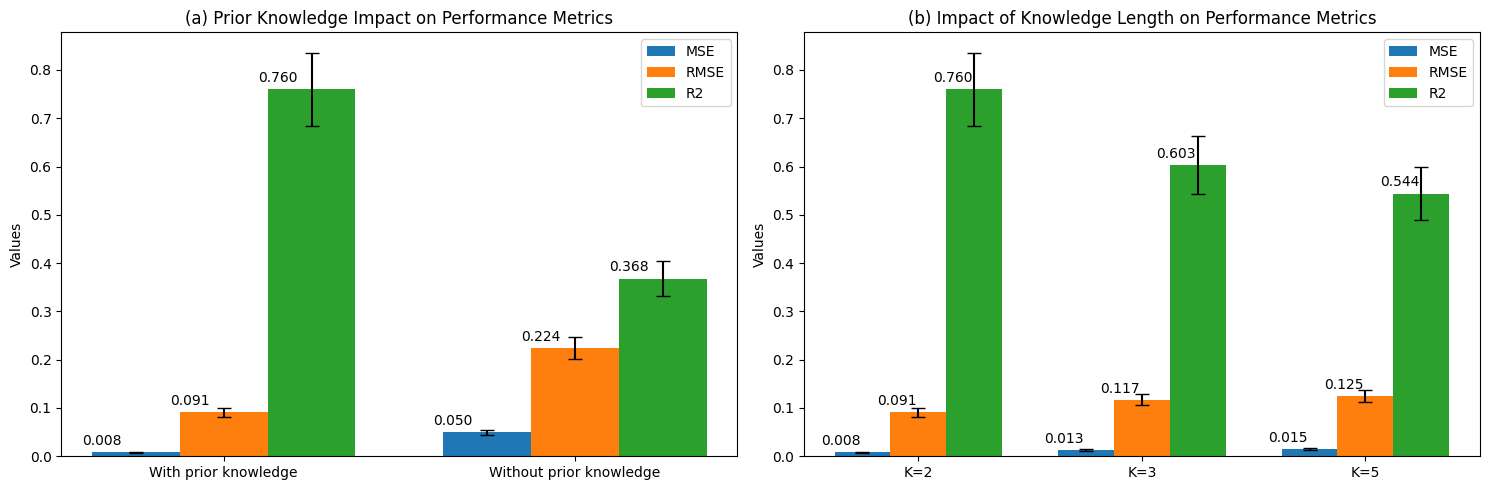

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 创建第一个数据框
data1 = {
    'Method': ['With prior knowledge', 'Without prior knowledge'],
    'MSE': [0.008, 0.05],
    'RMSE': [0.091, 0.224],
    'R2': [0.760, 0.368]
}
df1 = pd.DataFrame(data1)

# 创建第二个数据框
data2 = {
    'Knowledge Length': ['K=2', 'K=3', 'K=5'],
    'MSE': [0.008, 0.013, 0.015],
    'RMSE': [0.091, 0.117, 0.125],
    'R2': [0.76, 0.603, 0.544]
}
df2 = pd.DataFrame(data2)

# 计算误差（假设为值的10%）
error1 = {
    'MSE': df1['MSE'] * 0.1,
    'RMSE': df1['RMSE'] * 0.1,
    'R2': df1['R2'] * 0.1
}

error2 = {
    'MSE': df2['MSE'] * 0.1,
    'RMSE': df2['RMSE'] * 0.1,
    'R2': df2['R2'] * 0.1
}

# 设置图表风格
# plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制第一个图 (对比不同方法)
x = np.arange(len(df1['Method']))
width = 0.25

# 绘制柱状图和误差棒
bars1 = ax1.bar(x - width, df1['MSE'], width, label='MSE', yerr=error1['MSE'], capsize=5)
bars2 = ax1.bar(x, df1['RMSE'], width, label='RMSE', yerr=error1['RMSE'], capsize=5)
bars3 = ax1.bar(x + width, df1['R2'], width, label='R2', yerr=error1['R2'], capsize=5)

# 添加数值标签
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 9, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1, ax1)
autolabel(bars2, ax1)
autolabel(bars3, ax1)

ax1.set_ylabel('Values')
ax1.set_title('(a) Prior Knowledge Impact on Performance Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(df1['Method'])
ax1.legend()

# 绘制第二个图 (不同Knowledge Length的比较)
x = np.arange(len(df2['Knowledge Length']))
width = 0.25

# 绘制柱状图和误差棒
bars1 = ax2.bar(x - width, df2['MSE'], width, label='MSE', yerr=error2['MSE'], capsize=5)
bars2 = ax2.bar(x, df2['RMSE'], width, label='RMSE', yerr=error2['RMSE'], capsize=5)
bars3 = ax2.bar(x + width, df2['R2'], width, label='R2', yerr=error2['R2'], capsize=5)

# 添加数值标签
autolabel(bars1, ax2)
autolabel(bars2, ax2)
autolabel(bars3, ax2)

ax2.set_ylabel('Values')
ax2.set_title('(b) Impact of Knowledge Length on Performance Metrics')
ax2.set_xticks(x)
ax2.set_xticklabels(df2['Knowledge Length'])
ax2.legend()

# 调整布局
plt.tight_layout()
plt.savefig('./figure/performance_metrics_comparison.jpg', dpi=300)
plt.show()

## traditional predict method

In [123]:
import pandas as pd
df = pd.read_csv('ground_truth_train.csv')

# 假设CSV文件中最后一列是因变量，其余列是自变量
y = df.iloc[:, 6]  # 自变量
X = df.iloc[:, 7:]   # 因变量

In [144]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, shuffle=True)

# 通用参数设置
n_estimators = 100
learning_rate = 0.01
max_depth = 15
subsample = 0.8
random_state = 50
reg_alpha = 0.1  # L1正则化
reg_lambda = 0.1  # L2正则化

# LightGBM
lgb_reg = lgb.LGBMRegressor(objective="regression",
                            learning_rate=learning_rate,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            subsample=subsample,
                            colsample_bytree=0.8,
                            reg_alpha=reg_alpha,
                            reg_lambda=reg_lambda,
                            verbose=-1,
                            random_state=random_state)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=n_estimators,
                              max_depth=max_depth,
                              max_samples=subsample,  # 类似于subsample
                              random_state=random_state)

# Decision Tree
dt_reg = DecisionTreeRegressor(criterion='squared_error',
                              max_depth=max_depth,
                              random_state=random_state,
                              min_samples_split=2,
                              min_samples_leaf=10,
                              splitter='best')

# GBDT
gbdt_reg = GradientBoostingRegressor(n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    subsample=subsample,
                                    random_state=random_state)

# KNN (无法完全匹配其他模型的参数，保持原样)
knn_reg = KNeighborsRegressor(n_neighbors=5)

# XGBoost
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror",
                           learning_rate=learning_rate,
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           subsample=subsample,
                           colsample_bytree=0.8,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           tree_method='hist',
                           enable_categorical=True,
                           random_state=random_state)

# Linear Regression (参数较少，保持原样)
lr_reg = LinearRegression(n_jobs=10,
                         positive=True)

models = [
    # lgb_reg, 
    rf_reg, 
    dt_reg, 
    gbdt_reg, 
    knn_reg, 
    # xgb_reg, 
    lr_reg]

rm = []
rr = []
me = []

for model in models:
    # 使用5折交叉验证
    rmse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # mape = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    rm.append(np.mean(np.sqrt(-rmse)))
    me.append(np.mean(np.sqrt(-mse)))
    rr.append(np.mean(r2))

    print('Model:', type(model).__name__)
    print('RMSE:', np.mean(np.sqrt(-rmse)))
    print('MSE:', np.mean(np.sqrt(-mse)))
    print('R^2 Score:', np.mean(r2))
    print()

Model: RandomForestRegressor
RMSE: 0.38436367635113317
MSE: 0.14822703358103542
R^2 Score: 0.27562074540000686

Model: DecisionTreeRegressor
RMSE: 0.4162005759095145
MSE: 0.1737576502030955
R^2 Score: 0.008659328173720171

Model: GradientBoostingRegressor
RMSE: 0.39239453293500504
MSE: 0.154394036996825
R^2 Score: 0.22046860936638013

Model: KNeighborsRegressor
RMSE: 0.4164430074756769
MSE: 0.17357420936164575
R^2 Score: 0.01208584335668823

Model: LinearRegression
RMSE: 0.4088330155631124
MSE: 0.16740833050303552
R^2 Score: 0.07020702207847802



## Figure 7

       quality_class Features (Top5)  Value
0     Medium quality            road   0.28
1     Medium quality            road   0.27
2     Medium quality            road   0.21
3     Medium quality            road   0.32
4     Medium quality            road   0.36
...              ...             ...    ...
4660  Medium quality             sky   0.36
4661  Medium quality             sky   0.16
4662  Medium quality             sky   0.19
4663  Medium quality             sky   0.38
4664  Medium quality             sky   0.38

[4347 rows x 3 columns]


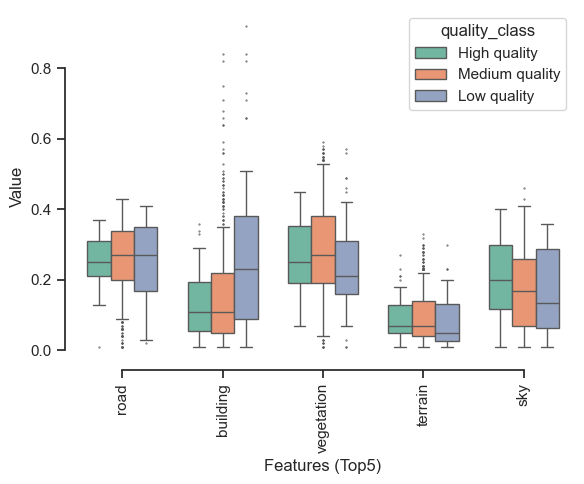

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="Set2")

df_wide = pd.read_csv("./result_data/classified_data2.csv")
# 载入数据到DataFrame
# df_wide = pd.DataFrame(tips)

# 将宽格式DataFrame转换为长格式DataFrame
df_long = df_wide.iloc[:,9:].melt(id_vars=['quality_class'], var_name='Features (Top5)', value_name='Value')
df_long = df_long[df_long['Value'] != 0]
print(df_long)

# Load the example tips dataset
# tips = sns.load_dataset("tips")
plt.subplots(figsize = (6, 5))

order = ['High quality', 'Medium quality', 'Low quality']
df_long['quality_class'] = pd.Categorical(df_long['quality_class'], categories=order, ordered=True)

# Draw a nested boxplot to show bills by day and time
# ax = sns.boxplot(x="Variable", y="Value",
#             hue="quality_class", 
#             # palette=["m", "g"],
#             data=df_long)

ax = sns.boxplot(x="Features (Top5)", y="Value",
            hue="quality_class", 
            data=df_long,
            # palette=["m", "g"],
            width=0.7,
            whis=0.8,
            fliersize=0.5,
            )

sns.despine(offset=5, trim=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# 调整布局
plt.tight_layout()
plt.savefig('./figure/box.jpg', dpi=300)
plt.show()

In [29]:
import pandas as pd
import numpy as np

try:
    # 读取CSV数据
    df = pd.read_csv('./result_data/evaluation_results_claude37_all.csv', encoding='ISO-8859-1')
    
    # 提取score列并转换为numpy数组
    scores = df['score'].values
    
    # 计算 25% 和 75% 分位
    low_th  = np.percentile(scores, 5)   # ≤ 25% → Low
    high_th = np.percentile(scores, 95)   # ≥ 75% → High

    breaks = [scores.min(), low_th, high_th, scores.max()]

    def get_quality_class(score):
        if score <= low_th:
            return 'Low quality'
        elif score >= high_th:
            return 'High quality'
        else:
            return 'Medium quality'

    df['quality_class'] = df['score'].apply(get_quality_class)

    # 打印断点值和每个类别的数量
    print("Break points:", breaks)
    print("\nClass distribution:")
    print(df['quality_class'].value_counts())
    print("\nBreak points details:")
    print(f"Low quality: <= {breaks[1]}")
    print(f"Medium quality: {breaks[1]} - {breaks[2]}")
    print(f"High quality: > {breaks[2]}")

    # 保存结果到新的CSV文件
    df.to_csv('./result_data/classified_data2.csv', index=False, encoding='utf-8')
    
except Exception as e:
    print(f"发生错误: {str(e)}")

Break points: [0.1169, 0.257236, 0.675, 0.8]

Class distribution:
Medium quality    838
High quality       48
Low quality        47
Name: quality_class, dtype: int64

Break points details:
Low quality: <= 0.257236
Medium quality: 0.257236 - 0.675
High quality: > 0.675


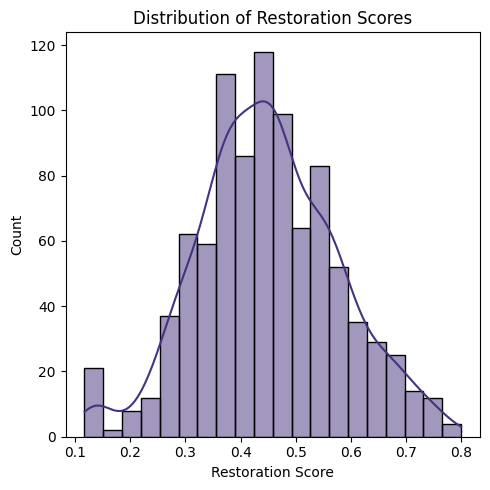

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Set style for academic figures
# plt.style.use('seaborn-whitegrid')
sns.set_palette("viridis")

# Load your data
df = pd.read_csv('./result_data/classified_data.csv')  # Replace with your actual file path

plt.figure(figsize=(5, 5))
sns.histplot(data=df, x='score', bins=20, kde=True)
plt.xlabel('Restoration Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Distribution of Restoration Scores', fontsize=12)
plt.tight_layout()
plt.savefig('./figure/score_distribution.png', bbox_inches='tight', dpi=300)
# plt.close()

In [ ]:
import pandas as pd
import openai
from openai import OpenAI
import json
from collections import defaultdict
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# 设置API
api_key = "sk-ya1SFXgvQYgK6WIhqO86iUEZVArXpu94L6g7HPXdy1aBTM84"
base_url = "https://api.zetatechs.com/v1/"

client = OpenAI(api_key=api_key, base_url=base_url)

# 读取CSV文件
df = pd.read_csv('./result_data/classified_data2.csv', encoding='gbk')  # 替换为您的文件路径
df = df[df['quality_class'] == 'Low quality']  # 只分析高质量数据

# 定义分析函数
def analyze_text_with_llm(text, analysis_type):
    prompts = {
        "fascination": """
        Analyze the following text and extract keywords related to spatial elements that contribute to fascination.
        Focus on identifying specific objects and descriptive terms that make the scene interesting.
        Return a JSON format with:
        {{
            "objects": [list of physical objects],
            "descriptors": [list of descriptive terms]
        }}
        Text: {text}
        """,
        "being_away": """
        Analyze the following text and extract keywords related to spatial elements that contribute to a sense of being away/escape.
        Focus on identifying specific objects and descriptive terms that create a sense of escape.
        Return a JSON format with:
        {{
            "objects": [list of physical objects],
            "descriptors": [list of descriptive terms]
        }}
        Text: {text}
        """,
        "coherence": """
        Analyze the following text and extract keywords related to spatial coherence/organization.
        Focus on identifying specific objects and descriptive terms that contribute to the sense of order.
        Return a JSON format with:
        {{
            "objects": [list of physical objects],
            "descriptors": [list of descriptive terms]
        }}
        Text: {text}
        """,
        "scope": """
        Analyze the following text and extract keywords related to spatial scope/openness.
        Focus on identifying specific objects and descriptive terms that contribute to the sense of space.
        Return a JSON format with:
        {{
            "objects": [list of physical objects],
            "descriptors": [list of descriptive terms]
        }}
        Text: {text}
        """
    }
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a professional spatial analysis assistant."},
                {"role": "user", "content": prompts[analysis_type].format(text=text)}
            ],
            response_format={"type": "json_object"},
            temperature=0.3
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        print(f"Error processing {analysis_type}: {e}")
        return {"objects": [], "descriptors": []}

def process_row(row):
    row_results = {}
    for metric in ["fascination", "being_away", "coherence", "scope"]:
        if pd.notna(row[f'reason_{metric}']):
            result = analyze_text_with_llm(row[f'reason_{metric}'], metric)
            row_results[metric] = result
        else:
            row_results[metric] = {"objects": [], "descriptors": []}
    return row_results

# 为每个指标初始化统计字典
stats = {
    "fascination": defaultdict(int),
    "being_away": defaultdict(int),
    "coherence": defaultdict(int),
    "scope": defaultdict(int)
}

# 使用线程池并行处理
with ThreadPoolExecutor(max_workers=10) as executor:  # 调整max_workers根据你的API速率限制
    futures = []
    for index, row in df.iterrows():
        futures.append(executor.submit(process_row, row))
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        row_results = future.result()
        for metric, result in row_results.items():
            for obj in result.get("objects", []):
                stats[metric][f"object_{obj.lower()}"] += 1
            for desc in result.get("descriptors", []):
                stats[metric][f"desc_{desc.lower()}"] += 1

# 为每个指标保存单独的CSV文件
for metric, metric_stats in stats.items():
    # 转换为DataFrame
    metric_df = pd.DataFrame.from_dict(metric_stats, orient='index', columns=['count']).reset_index()
    metric_df.columns = ['keyword', 'count']
    metric_df['type'] = metric_df['keyword'].apply(lambda x: 'object' if x.startswith('object_') else 'descriptor')
    metric_df['keyword'] = metric_df['keyword'].str.replace('object_', '').str.replace('desc_', '')
    
    # 按count降序排序
    metric_df = metric_df.sort_values(by='count', ascending=False)
    
    # 保存到CSV
    filename = f"./result_data/{metric}_analysis_results_low_quality.csv"
    metric_df.to_csv(filename, index=False)
    print(f"Saved {filename}")

print("All analyses completed and saved.")

100%|██████████| 47/47 [00:33<00:00,  1.39it/s]

Saved ./result_data/fascination_analysis_results_low_quality.csv
Saved ./result_data/being_away_analysis_results_low_quality.csv
Saved ./result_data/coherence_analysis_results_low_quality.csv
Saved ./result_data/scope_analysis_results_low_quality.csv
All analyses completed and saved.


C:\Users\浩然\AppData\Local\Temp\ipykernel_21764\3624763151.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


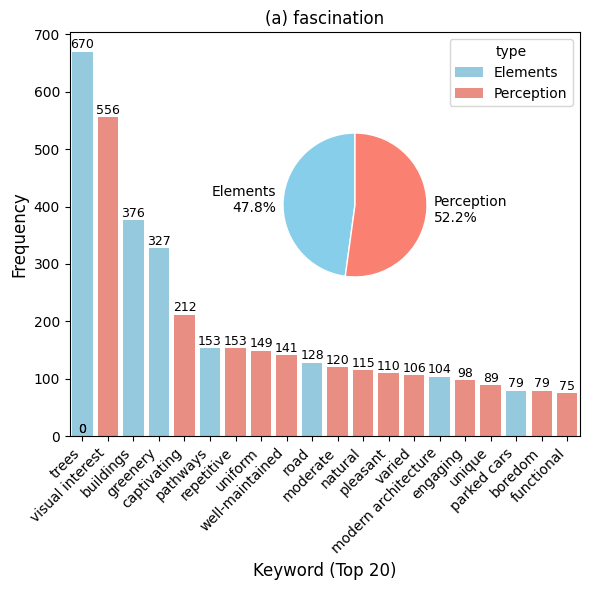

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./result_data/fascination_analysis_results.csv')

# Replace type labels
df['type'] = df['type'].replace({'object': 'Elements', 'descriptor': 'Perception'})

# 按计数排序并取前10
df_top10 = df.sort_values('count', ascending=False).head(20)

# 设置图形大小
plt.figure(figsize=(6, 6))

# 创建柱状图，按类型着色
barplot = sns.barplot(
    x='keyword', 
    y='count', 
    # hue='type', 
    data=df_top10,
    palette={'Elements': 'skyblue', 'Perception': 'salmon'},
    # dodge=False  # 不分组显示
)

# 添加标题和标签
plt.xlabel('Keyword (Top 20)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('(a) fascination', fontsize=12)
# 旋转x轴标签以便更好地显示
plt.xticks(rotation=45, ha='right')

# 在柱子上方显示计数值
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 5), fontsize=9,
                   textcoords='offset points')

# 计算两种类型的比例
type_counts = df_top10.groupby('type')['count'].sum()
total = type_counts.sum()
percentages = type_counts / total * 100

# 创建扇形图的位置和大小
pie_x = 0.45  # x坐标位置（图形比例）
pie_y = 0.5  # y坐标位置（图形比例）
pie_size = 0.3  # 扇形图大小

# 在柱状图上添加扇形图
pie_ax = plt.gcf().add_axes([pie_x, pie_y, pie_size, pie_size])
pie_ax.pie(percentages, 
           labels=[f'{t}\n{p:.1f}%' for t, p in zip(percentages.index, percentages)],
           colors=['skyblue', 'salmon'],
           startangle=90,
           wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
# pie_ax.set_title('Type Distribution', fontsize=10, loc='center')

# 调整布局防止标签被截断
plt.tight_layout()
plt.savefig('./figure/keyword_fascination.png', bbox_inches='tight', dpi=300)
# 显示图形
plt.show()

In [92]:
import pandas as pd

# 文件列表
file_names = [
    './result_data/scope_analysis_results_high_quality.csv',
    './result_data/fascination_analysis_results_high_quality.csv',
    './result_data/being_away_analysis_results_high_quality.csv',
    './result_data/coherence_analysis_results_high_quality.csv'
]

# 读取并合并所有CSV文件
combined_df = pd.concat([pd.read_csv(file) for file in file_names])

# 按keyword和type分组，对count求和
final_result = combined_df.groupby(['keyword', 'type'])['count'].sum().reset_index()

# 按count降序排序
final_result = final_result.sort_values('count', ascending=False)

# 保存为CSV文件
final_result.to_csv('./result_data/combined_keyword_stats_high_quality.csv', index=False)

print("合并后的关键词统计已保存为 combined_keyword_stats.csv")

合并后的关键词统计已保存为 combined_keyword_stats.csv


C:\Users\浩然\AppData\Local\Temp\ipykernel_21764\1119147655.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


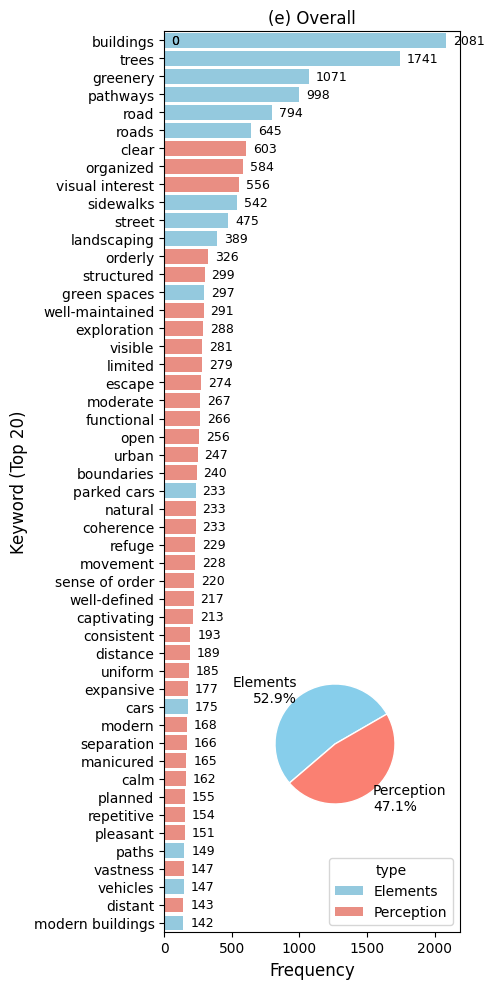

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./result_data/combined_keyword_stats.csv')

# Replace type labels
df['type'] = df['type'].replace({'object': 'Elements', 'descriptor': 'Perception'})

# 按计数排序并取前10
df_top10 = df.sort_values('count', ascending=False).head(50)

# 设置图形大小
plt.figure(figsize=(5, 10))

# 创建柱状图，按类型着色
barplot = sns.barplot(
    y='keyword', 
    x='count', 
    hue='type', 
    data=df_top10,
    palette={'Elements': 'skyblue', 'Perception': 'salmon'},
    # dodge=False  # 不分组显示
)

# 添加标题和标签
plt.ylabel('Keyword (Top 20)', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.title('(e) Overall', fontsize=12)
# 旋转x轴标签以便更好地显示
# plt.xticks(rotation=45, ha='right')

# 在柱子上方显示计数值
for p in barplot.patches:
    # 现在使用p.get_width()而不是p.get_height()，因为柱子是水平的
    barplot.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width(), p.get_y() + p.get_height()/2.),  # x坐标是宽度，y坐标是柱子中心
                   ha='left', va='center',  # 水平对齐改为left，垂直居中
                   xytext=(5, 0), fontsize=9,  # 向右偏移5个单位
                   textcoords='offset points')

# 计算两种类型的比例
type_counts = df_top10.groupby('type')['count'].sum()
total = type_counts.sum()
percentages = type_counts / total * 100

# 创建扇形图的位置和大小
pie_x = 0.53  # x坐标位置（图形比例）
pie_y = 0.1  # y坐标位置（图形比例）
pie_size = 0.3  # 扇形图大小

# 在柱状图上添加扇形图
pie_ax = plt.gcf().add_axes([pie_x, pie_y, pie_size, pie_size])
pie_ax.pie(percentages, 
           labels=[f'{t}\n{p:.1f}%' for t, p in zip(percentages.index, percentages)],
           colors=['skyblue', 'salmon'],
           startangle=30,
           wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
# pie_ax.set_title('Type Distribution', fontsize=10, loc='center')

# 调整布局防止标签被截断
plt.tight_layout()
plt.savefig('./figure/keyword_overall.png', bbox_inches='tight', dpi=300)
# 显示图形
plt.show()

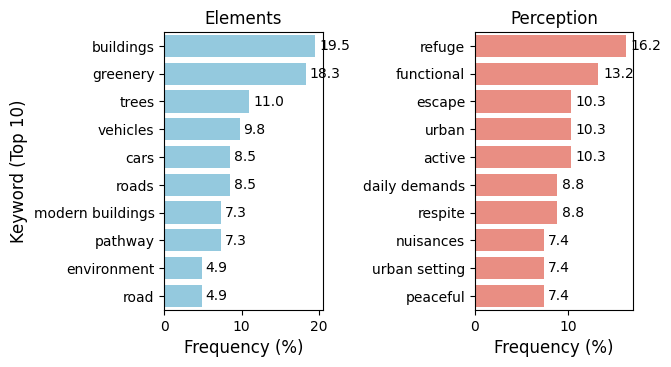

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./result_data/being_away_analysis_results_low_quality.csv')

# 按类型分组
df_object = df[df['type'] == 'object'].sort_values('count', ascending=False).head(10)
df_descriptor = df[df['type'] == 'descriptor'].sort_values('count', ascending=False).head(10)
df_object['percentage'] = (df_object['count'] / df_object['count'].sum()) * 100
df_descriptor['percentage'] = (df_descriptor['count'] / df_descriptor['count'].sum()) * 100

# 创建一行两列的子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8, 4))

# 第一个子图 - object类型
sns.barplot(
    x='percentage', 
    y='keyword', 
    data=df_object,
    color='skyblue',
    ax=ax1
)
ax1.set_title('Elements', fontsize=12)
ax1.set_xlabel('Frequency (%)', fontsize=12)
ax1.set_ylabel('Keyword (Top 10)', fontsize=12)

# 在柱子上显示数值
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.5, p.get_y() + p.get_height()/2, 
            '{:1.1f}'.format(width),  # 添加%符号
            ha='left', va='center')

# 第二个子图 - descriptor类型
sns.barplot(
    x='percentage', 
    y='keyword', 
    data=df_descriptor,
    color='salmon',
    ax=ax2
)
ax2.set_title('Perception', fontsize=12)
ax2.set_xlabel('Frequency (%)', fontsize=12)
ax2.set_ylabel('')

# 在柱子上显示数值
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.5, p.get_y() + p.get_height()/2, 
            '{:1.1f}'.format(width),  # 添加%符号
            ha='left', va='center')

# 调整整体标题和布局
# plt.suptitle('Top 10 Keywords by Type', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 为总标题留出空间
plt.savefig('./figure/being_away_analysis_low_quality.png', bbox_inches='tight', dpi=300)
plt.show()

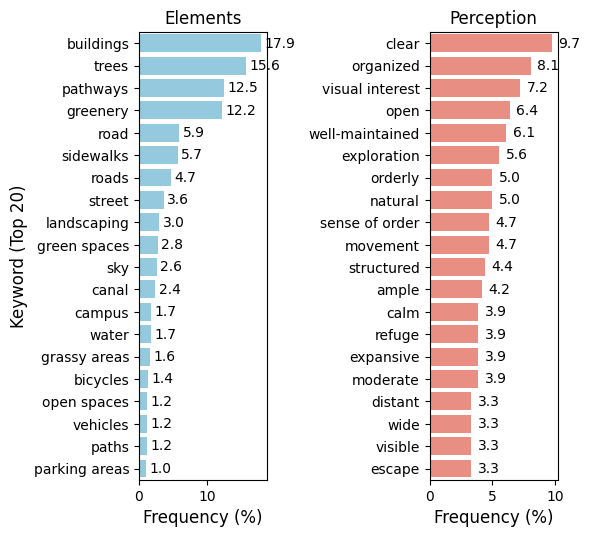

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./result_data/combined_keyword_stats_high_quality.csv')

# 按类型分组
df_object = df[df['type'] == 'object'].sort_values('count', ascending=False).head(20)
df_descriptor = df[df['type'] == 'descriptor'].sort_values('count', ascending=False).head(20)
df_object['percentage'] = (df_object['count'] / df_object['count'].sum()) * 100
df_descriptor['percentage'] = (df_descriptor['count'] / df_descriptor['count'].sum()) * 100

# 创建一行两列的子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

# 第一个子图 - object类型
sns.barplot(
    x='percentage', 
    y='keyword', 
    data=df_object,
    color='skyblue',
    ax=ax1
)
ax1.set_title('Elements', fontsize=12)
ax1.set_xlabel('Frequency (%)', fontsize=12)
ax1.set_ylabel('Keyword (Top 20)', fontsize=12)

# 在柱子上显示数值
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.5, p.get_y() + p.get_height()/2, 
            '{:1.1f}'.format(width),  # 添加%符号
            ha='left', va='center')

# 第二个子图 - descriptor类型
sns.barplot(
    x='percentage', 
    y='keyword', 
    data=df_descriptor,
    color='salmon',
    ax=ax2
)
ax2.set_title('Perception', fontsize=12)
ax2.set_xlabel('Frequency (%)', fontsize=12)
ax2.set_ylabel('')

# 在柱子上显示数值
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.5, p.get_y() + p.get_height()/2, 
            '{:1.1f}'.format(width),  # 添加%符号
            ha='left', va='center')

# 调整整体标题和布局
# plt.suptitle('Top 10 Keywords by Type', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 为总标题留出空间
plt.savefig('./figure/analysis_high_quality.png', bbox_inches='tight', dpi=300)
plt.show()


Analysis for reason_fascination:
nodes: 145
edges: 2489
density: 0.23840996168582376
avg_degree: 34.33103448275862
top_nodes_by_degree: [('trees', 129), ('buildings', 121), ('fascination', 116), ('engaging', 113), ('greenery', 96)]

Analysis for reason_being_away:
nodes: 141
edges: 2384
density: 0.24154002026342453
avg_degree: 33.815602836879435
top_nodes_by_degree: [('escape', 139), ('environment', 122), ('refuge', 115), ('buildings', 102), ('everyday', 97)]

Analysis for reason_coherence:
nodes: 146
edges: 2445
density: 0.2309872461029759
avg_degree: 33.49315068493151
top_nodes_by_degree: [('clear', 136), ('arrangement', 133), ('order', 128), ('buildings', 123), ('organized', 109)]

Analysis for reason_scope:
nodes: 151
edges: 2811
density: 0.24821192052980132
avg_degree: 37.2317880794702
top_nodes_by_degree: [('exploration', 149), ('buildings', 143), ('boundaries', 123), ('open', 111), ('limited', 110)]

Strongest object-descriptor pairs for reason_fascination:
Descriptor: trees, S

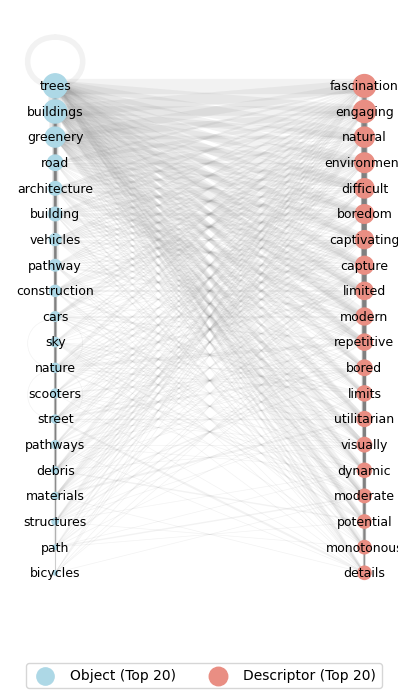


Top 20 Object nodes in Network for reason_fascination:
trees: 129
buildings: 121
greenery: 96
road: 66
architecture: 56
building: 56
vehicles: 48
pathway: 47
construction: 45
cars: 39
sky: 38
nature: 37
scooters: 36
street: 34
pathways: 34
debris: 31
materials: 31
structures: 30
path: 26
bicycles: 26

Top 20 Descriptor nodes in Network for reason_fascination:
fascination: 116
engaging: 113
natural: 96
environment: 93
difficult: 91
boredom: 86
captivating: 82
capture: 81
limited: 77
modern: 75
repetitive: 70
bored: 66
limits: 64
utilitarian: 63
visually: 61
dynamic: 59
moderate: 56
potential: 55
monotonous: 55
details: 55

Analysis for reason_being_away:
nodes: 141
edges: 2384
density: 0.24154002026342453
avg_degree: 33.815602836879435
top_nodes_by_degree: [('escape', 139), ('environment', 122), ('refuge', 115), ('buildings', 102), ('everyday', 97)]


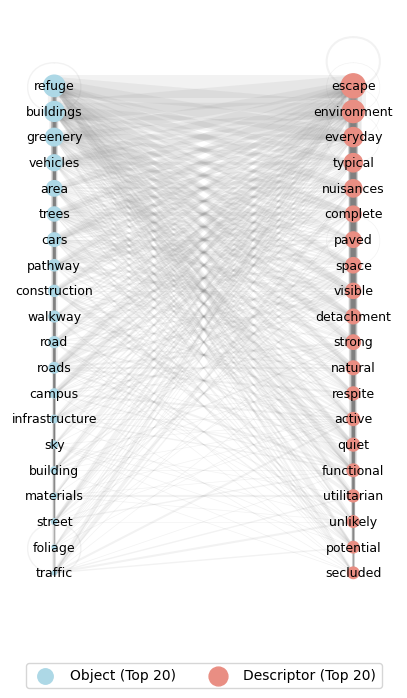


Top 20 Object nodes in Network for reason_being_away:
refuge: 115
buildings: 102
greenery: 86
vehicles: 74
area: 72
trees: 64
cars: 61
pathway: 50
construction: 49
walkway: 48
road: 48
roads: 47
campus: 41
infrastructure: 36
sky: 35
building: 34
materials: 31
street: 31
foliage: 29
traffic: 29

Top 20 Descriptor nodes in Network for reason_being_away:
escape: 139
environment: 122
everyday: 97
typical: 91
nuisances: 84
complete: 74
paved: 72
space: 71
visible: 70
detachment: 67
strong: 66
natural: 62
respite: 58
active: 58
quiet: 57
functional: 56
utilitarian: 53
unlikely: 51
potential: 51
secluded: 51

Analysis for reason_coherence:
nodes: 146
edges: 2445
density: 0.2309872461029759
avg_degree: 33.49315068493151
top_nodes_by_degree: [('clear', 136), ('arrangement', 133), ('order', 128), ('buildings', 123), ('organized', 109)]


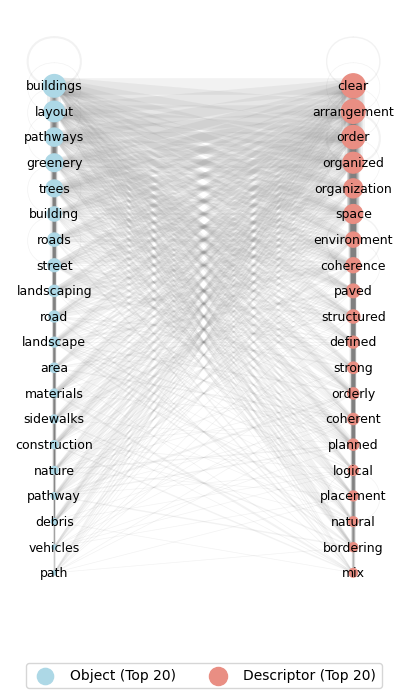


Top 20 Object nodes in Network for reason_coherence:
buildings: 123
layout: 107
pathways: 90
greenery: 87
trees: 81
building: 67
roads: 62
street: 60
landscaping: 53
road: 52
landscape: 48
area: 46
materials: 44
sidewalks: 42
construction: 42
nature: 41
pathway: 38
debris: 37
vehicles: 34
path: 34

Top 20 Descriptor nodes in Network for reason_coherence:
clear: 136
arrangement: 133
order: 128
organized: 109
organization: 96
space: 95
environment: 72
coherence: 71
paved: 64
structured: 62
defined: 56
strong: 54
orderly: 53
coherent: 53
planned: 53
logical: 49
placement: 48
natural: 47
bordering: 45
mix: 44

Analysis for reason_scope:
nodes: 151
edges: 2811
density: 0.24821192052980132
avg_degree: 37.2317880794702
top_nodes_by_degree: [('exploration', 149), ('buildings', 143), ('boundaries', 123), ('open', 111), ('limited', 110)]


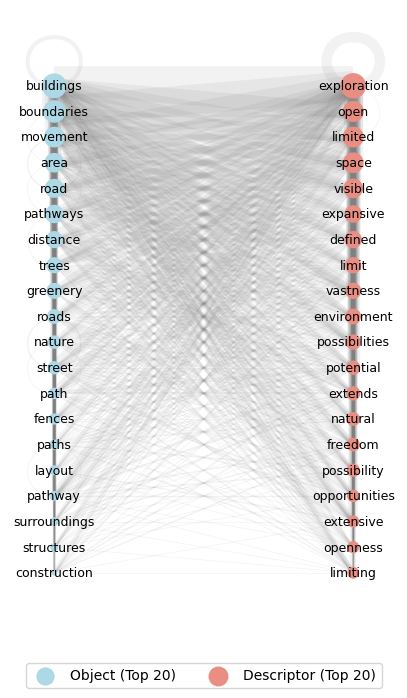


Top 20 Object nodes in Network for reason_scope:
buildings: 143
boundaries: 123
movement: 109
area: 100
road: 96
pathways: 92
distance: 83
trees: 77
greenery: 76
roads: 69
nature: 63
street: 62
path: 54
fences: 53
paths: 49
layout: 49
pathway: 48
surroundings: 44
structures: 43
construction: 38

Top 20 Descriptor nodes in Network for reason_scope:
exploration: 149
open: 111
limited: 110
space: 108
visible: 100
expansive: 86
defined: 84
limit: 78
vastness: 77
environment: 75
possibilities: 72
potential: 67
extends: 67
natural: 64
freedom: 63
possibility: 62
opportunities: 59
extensive: 57
openness: 57
limiting: 56


In [ ]:
import pandas as pd
import networkx as nx
import re
from collections import defaultdict
import matplotlib.pyplot as plt

# 读取关键词数据
def load_keywords(keywords_data, exclude_words_by_type=None):
    """
    从DataFrame加载关键词并过滤
    keywords_data: 包含关键词的DataFrame
    exclude_words_by_type: 字典，按类型指定要排除的关键词 {'object': [...], 'descriptor': [...]}
    """
    if exclude_words_by_type is None:
        exclude_words_by_type = {'object': [], 'descriptor': []}
    
    # 创建关键词字典
    keyword_dict = {}
    for _, row in keywords_data.iterrows():
        word_type = row['type']
        word = row['keyword']
        
        # 检查是否在排除列表中
        if word not in exclude_words_by_type.get(word_type, []):
            keyword_dict[word] = {
                'type': word_type,
                'count': row['count']
            }
    
    return keyword_dict

# 文本预处理
def preprocess_text(text):
    # 转换为小写
    text = text.lower()
    # 移除标点符号
    text = re.sub(r'[^\w\s]', ' ', text)
    return text

# 在文本中找到关键词
def find_keywords_in_text(text, keyword_dict):
    text = preprocess_text(text)
    words = text.split()
    found_keywords = []
    
    for word in words:
        if word in keyword_dict:
            found_keywords.append(word)
    
    return found_keywords

# 创建图
def create_graph(texts, keyword_dict, reason_column):
    G = nx.Graph()
    
    # 为每个文本创建边
    for text in texts:
        keywords = find_keywords_in_text(text, keyword_dict)
        
        # 在找到的关键词之间创建边
        for i in range(len(keywords)):
            for j in range(i + 1, len(keywords)):
                if not G.has_edge(keywords[i], keywords[j]):
                    G.add_edge(keywords[i], keywords[j], weight=1)
                else:
                    # 如果边已存在，增加权重
                    G[keywords[i]][keywords[j]]['weight'] += 1
    
    return G

# 分析图
def analyze_graph(G):
    analysis = {
        'nodes': len(G.nodes()),
        'edges': len(G.edges()),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / len(G),
        'top_nodes_by_degree': sorted(G.degree(), key=lambda x: x[1], reverse=True)[:5]
    }
    return analysis


def visualize_graph(G, keyword_dict, title, min_count=5, excluded_words=None):
    # 首先过滤关键词
    
    # 创建新的子图，只包含过滤后的节点
    filtered_nodes = list(keyword_dict.keys())
    filtered_G = G.subgraph(filtered_nodes)
    
    plt.figure(figsize=(5, 8))
    
    # 分别获取object和descriptor的top20节点
    object_nodes_all = [(node, filtered_G.degree(node)) for node in filtered_G.nodes() 
                       if keyword_dict[node]['type'] == 'object']
    descriptor_nodes_all = [(node, filtered_G.degree(node)) for node in filtered_G.nodes() 
                          if keyword_dict[node]['type'] == 'descriptor']
    
    # 按degree排序并获取top20
    top_object_nodes = sorted(object_nodes_all, key=lambda x: x[1], reverse=True)[:20]
    top_descriptor_nodes = sorted(descriptor_nodes_all, key=lambda x: x[1], reverse=True)[:20]
    
    # 获取所有top节点的名称
    top_node_names = [node[0] for node in top_object_nodes + top_descriptor_nodes]
    
    # 创建子图
    subG = filtered_G.subgraph(top_node_names)
    
    # 创建自定义布局
    pos = {}
    
    # object节点放在左边
    object_nodes = [node[0] for node in top_object_nodes]
    for i, node in enumerate(object_nodes):
        pos[node] = (-2, (len(object_nodes)/2 - i)/2)  # x=-2，y均匀分布
    
    # descriptor节点放在右边
    descriptor_nodes = [node[0] for node in top_descriptor_nodes]
    for i, node in enumerate(descriptor_nodes):
        pos[node] = (2, (len(descriptor_nodes)/2 - i)/2)  # x=2，y均匀分布

    # 获取所有节点的度数（从 top_object_nodes 和 top_descriptor_nodes 中提取）
    all_degrees = [d for (_, d) in top_object_nodes + top_descriptor_nodes]

    # 定义最小/最大度数
    min_degree = min(all_degrees)
    max_degree = max(all_degrees)

    # 定义目标大小范围
    min_size = 10  # 最小节点大小
    max_size = 300  # 最大节点大小

    # 规范化函数：将 degree 线性映射到 [min_size, max_size]
    def normalize_size(degree):
        if max_degree == min_degree:  # 避免除以零（所有 degree 相同时）
            return (min_size + max_size) / 2
        return min_size + (max_size - min_size) * (degree - min_degree) / (max_degree - min_degree)

    # 绘制object节点
    nx.draw_networkx_nodes(subG, pos, 
                        nodelist=object_nodes,
                        node_color='lightblue',
                        node_size=[normalize_size(d) for (_, d) in top_object_nodes],
                        label='Object (Top 20)')

    # 绘制descriptor节点
    nx.draw_networkx_nodes(subG, pos, 
                        nodelist=descriptor_nodes,
                        node_color='#E98E83',
                        node_size=[normalize_size(d) for (_, d) in top_descriptor_nodes],
                        label='Descriptor (Top 20)')
    
    # 绘制边
    edge_weights = [subG[u][v]['weight']*0.5 for u, v in subG.edges()]
    nx.draw_networkx_edges(subG, pos, width=edge_weights, alpha=0.1, 
                          edge_color='gray')
    
    # 添加节点标签，调整位置避免重叠
    nx.draw_networkx_labels(subG, pos, font_size=9)
    
    # plt.title(f"{title}\n(Top 20 nodes for each type, min_count={min_count})")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    plt.axis('off')

    plt.savefig(f'./figure/{title}_low_network.png', bbox_inches='tight', dpi=300)
    plt.show()
    
    # 打印节点度数信息
    print(f"\nTop 20 Object nodes in {title}:")
    for node, degree in top_object_nodes:
        print(f"{node}: {degree}")
        
    print(f"\nTop 20 Descriptor nodes in {title}:")
    for node, degree in top_descriptor_nodes:
        print(f"{node}: {degree}")

def find_strongest_descriptors_for_objects(G, keyword_dict):
    # 存储每个object的所有关联descriptor
    object_descriptors = defaultdict(list)
    
    for edge in G.edges(data=True):
        node1, node2, data = edge
        weight = data['weight']
        
        # 确保分类正确的配对
        if keyword_dict[node1]['type'] == 'object' and keyword_dict[node2]['type'] == 'descriptor':
            object_descriptors[node1].append((node2, weight))
        elif keyword_dict[node2]['type'] == 'object' and keyword_dict[node1]['type'] == 'descriptor':
            object_descriptors[node2].append((node1, weight))

    strongest_pairs = {}
    for object_node, descriptors in object_descriptors.items():
        if descriptors:  # 确保有关联的descriptors
            strongest_descriptor = max(descriptors, key=lambda x: x[1])
            strongest_pairs[object_node] = strongest_descriptor
    
    # 按权重排序
    sorted_pairs = sorted(strongest_pairs.items(), key=lambda x: x[1][1], reverse=True)
    return sorted_pairs[:20]

def main():
    # 假设我们有两个DataFrame: keywords_df 和 texts_df
    # 创建示例数据
    keywords_data = pd.read_csv('./result_data/combined_keyword_stats_low_quality.csv')
    # 读取文本数据
    texts_data = pd.read_csv('./result_data/classified_data2.csv')  # 替换为实际的文件路径
    texts_data = texts_data[texts_data['quality_class'] == 'Low quality']  # 只分析低质量数据

    # 获取关键词字典
    exclude_words_by_type = {
        'object': [
            'scene', 'areas', 'urban','elements'
        ],
        'descriptor': [
            'presence', 'overall', 'visual', 'urban', 'scene', 'elements', 'sense', 'some',
            'daily'
        ]
    }

    # 获取过滤后的关键词字典
    keyword_dict = load_keywords(keywords_data, exclude_words_by_type)

    # 为每个reason创建图
    reasons = ['reason_fascination', 'reason_being_away', 'reason_coherence', 'reason_scope']
    graphs = {}
    analyses = {}
    
    for reason in reasons:
        # 创建图
        graphs[reason] = create_graph(texts_data[reason], keyword_dict, reason)
        # 分析图
        analyses[reason] = analyze_graph(graphs[reason])
        
        print(f"\nAnalysis for {reason}:")
        for metric, value in analyses[reason].items():
            print(f"{metric}: {value}")
    
    # 分析每个reason图中的最强配对
    for reason, G in graphs.items():
        print(f"\nStrongest object-descriptor pairs for {reason}:")
        strongest_pairs = find_strongest_descriptors_for_objects(G, keyword_dict)
        for descriptor, (object_, weight) in strongest_pairs:
            print(f"Descriptor: {descriptor}, Strongest object: {object_}, Weight: {weight}")
            
    # 为每个reason创建和可视化图
    for reason in reasons:
        G = create_graph(texts_data[reason], keyword_dict, reason)
        analysis = analyze_graph(G)
        
        print(f"\nAnalysis for {reason}:")
        for metric, value in analysis.items():
            print(f"{metric}: {value}")
            
        visualize_graph(G, keyword_dict, f"Network for {reason}")

if __name__ == "__main__":
    main()

## high_node_degree

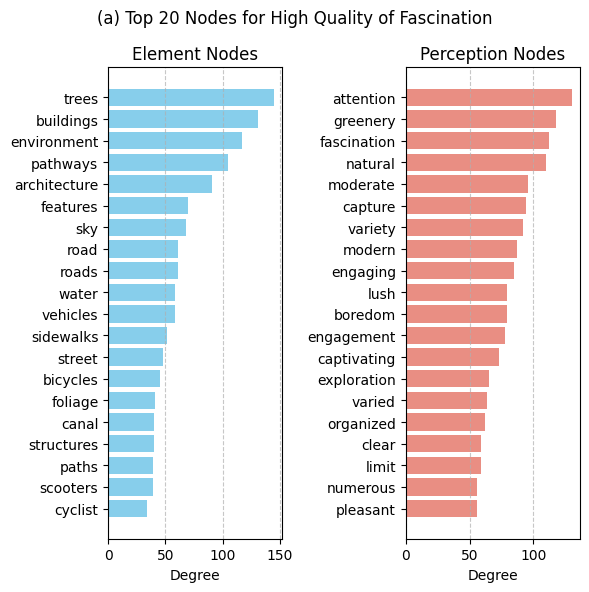

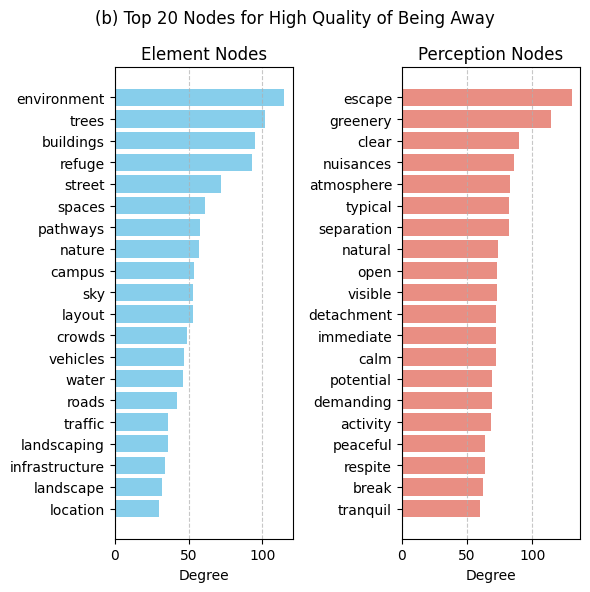

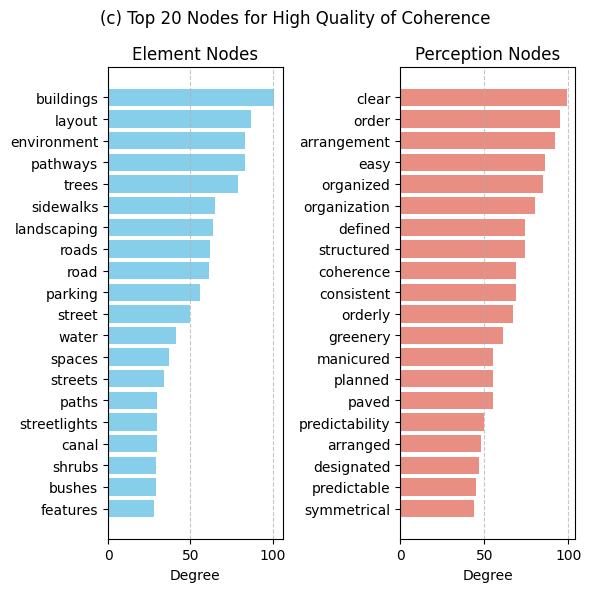

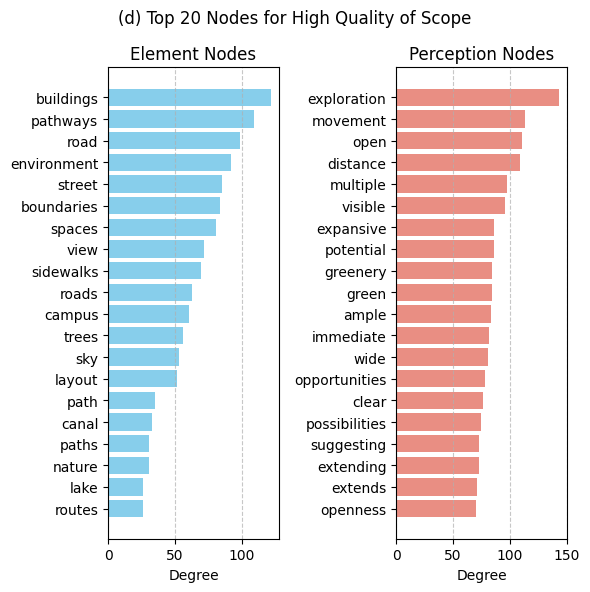

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = {
    'fascination': {
        'Objects': {
            'trees': 145, 'buildings': 131, 'environment': 117, 'pathways': 105, 'architecture': 91,
            'features': 70, 'sky': 68, 'road': 61, 'roads': 61, 'water': 58, 'vehicles': 58,
            'sidewalks': 51, 'street': 48, 'bicycles': 45, 'foliage': 41, 'canal': 40,
            'structures': 40, 'paths': 39, 'scooters': 39, 'cyclist': 34
        },
        'Descriptors': {
            'attention': 130, 'greenery': 118, 'fascination': 112, 'natural': 110, 'moderate': 96,
            'capture': 94, 'variety': 92, 'modern': 87, 'engaging': 85, 'lush': 79, 'boredom': 79,
            'engagement': 78, 'captivating': 73, 'exploration': 65, 'varied': 64, 'organized': 62,
            'clear': 59, 'limit': 59, 'numerous': 56, 'pleasant': 56
        }
    },
    'being_away': {
        'Objects': {
            'environment': 115, 'trees': 102, 'buildings': 95, 'refuge': 93, 'street': 72,
            'spaces': 61, 'pathways': 58, 'nature': 57, 'campus': 54, 'sky': 53, 'layout': 53,
            'crowds': 49, 'vehicles': 47, 'water': 46, 'roads': 42, 'traffic': 36, 'landscaping': 36,
            'infrastructure': 34, 'landscape': 32, 'location': 30
        },
        'Descriptors': {
            'escape': 130, 'greenery': 114, 'clear': 90, 'nuisances': 86, 'atmosphere': 83,
            'typical': 82, 'separation': 82, 'natural': 74, 'open': 73, 'visible': 73,
            'detachment': 72, 'immediate': 72, 'calm': 72, 'potential': 69, 'demanding': 69,
            'activity': 68, 'peaceful': 64, 'respite': 64, 'break': 62, 'tranquil': 60
        }
    },
    'coherence': {
        'Objects': {
            'buildings': 101, 'layout': 87, 'environment': 83, 'pathways': 83, 'trees': 79,
            'sidewalks': 65, 'landscaping': 64, 'roads': 62, 'road': 61, 'parking': 56,
            'street': 50, 'water': 41, 'spaces': 37, 'streets': 34, 'paths': 30, 'streetlights': 30,
            'canal': 30, 'shrubs': 29, 'bushes': 29, 'features': 28
        },
        'Descriptors': {
            'clear': 99, 'order': 95, 'arrangement': 92, 'easy': 86, 'organized': 85,
            'organization': 80, 'defined': 74, 'structured': 74, 'coherence': 69, 'consistent': 69,
            'orderly': 67, 'greenery': 61, 'manicured': 55, 'planned': 55, 'paved': 55,
            'predictability': 50, 'arranged': 48, 'designated': 47, 'predictable': 45,
            'symmetrical': 44
        }
    },
    'scope': {
        'Objects': {
            'buildings': 122, 'pathways': 109, 'road': 99, 'environment': 92, 'street': 85,
            'boundaries': 84, 'spaces': 81, 'view': 72, 'sidewalks': 70, 'roads': 63, 'campus': 61,
            'trees': 56, 'sky': 53, 'layout': 52, 'path': 35, 'canal': 33, 'paths': 31, 'nature': 31,
            'lake': 26, 'routes': 26
        },
        'Descriptors': {
            'exploration': 143, 'movement': 113, 'open': 111, 'distance': 109, 'multiple': 97,
            'visible': 96, 'expansive': 86, 'potential': 86, 'greenery': 84, 'green': 84, 'ample': 83,
            'immediate': 82, 'wide': 81, 'opportunities': 78, 'clear': 76, 'possibilities': 75,
            'suggesting': 73, 'extending': 73, 'extends': 71, 'openness': 70
        }
    }
}

numbs = ['(a)', '(b)', '(c)', '(d)']
# Create visualizations
for i, (reason, data) in enumerate(categories.items()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(f'{numbs[i]} Top 20 Nodes for High Quality of {reason.replace("_", " ").title()}')
    
    # Objects plot
    objects = data['Objects']
    ax1.barh(list(objects.keys())[::-1], list(objects.values())[::-1], color='skyblue')
    ax1.set_title('Element Nodes')
    ax1.set_xlabel('Degree')
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Descriptors plot
    descriptors = data['Descriptors']
    ax2.barh(list(descriptors.keys())[::-1], list(descriptors.values())[::-1], color='#E98E83')
    ax2.set_title('Perception Nodes')
    ax2.set_xlabel('Degree')
    ax2.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'./figure/{reason}_top_high_nodes.png', bbox_inches='tight', dpi=300)
    plt.show()

## low_node_degree

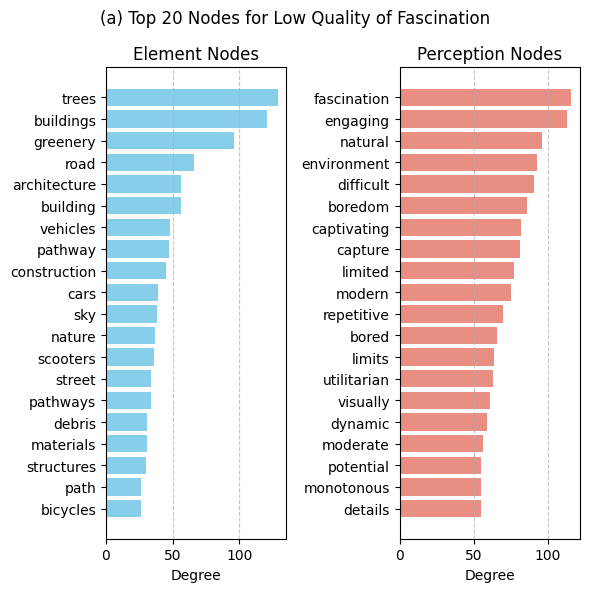

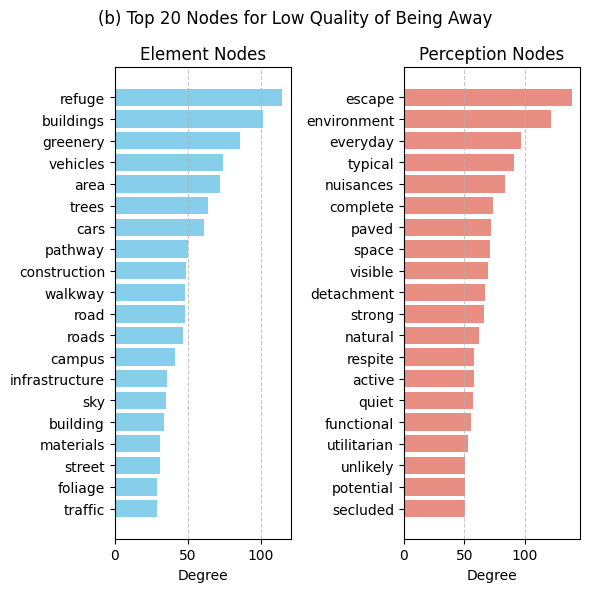

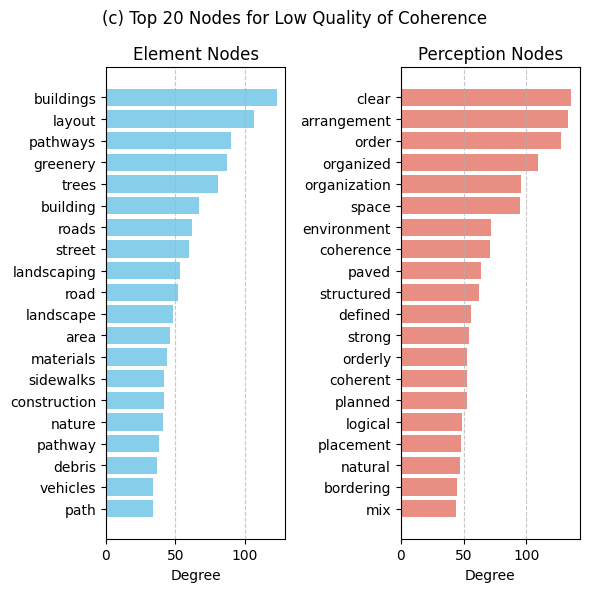

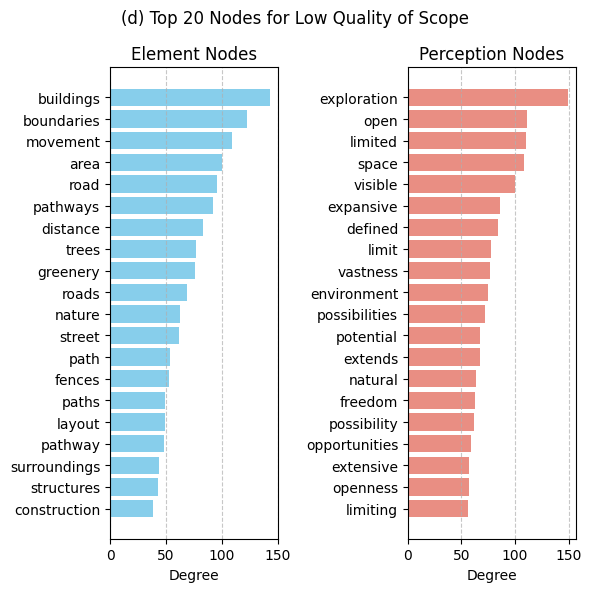

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = {
    "fascination": {
        "Objects": {
            "trees": 129, "buildings": 121, "greenery": 96, "road": 66, "architecture": 56,
            "building": 56, "vehicles": 48, "pathway": 47, "construction": 45, "cars": 39,
            "sky": 38, "nature": 37, "scooters": 36, "street": 34, "pathways": 34,
            "debris": 31, "materials": 31, "structures": 30, "path": 26, "bicycles": 26
        },
        "Descriptors": {
            "fascination": 116, "engaging": 113, "natural": 96, "environment": 93, "difficult": 91,
            "boredom": 86, "captivating": 82, "capture": 81, "limited": 77, "modern": 75,
            "repetitive": 70, "bored": 66, "limits": 64, "utilitarian": 63, "visually": 61,
            "dynamic": 59, "moderate": 56, "potential": 55, "monotonous": 55, "details": 55
        }
    },
    "being_away": {
        "Objects": {
            "refuge": 115, "buildings": 102, "greenery": 86, "vehicles": 74, "area": 72,
            "trees": 64, "cars": 61, "pathway": 50, "construction": 49, "walkway": 48,
            "road": 48, "roads": 47, "campus": 41, "infrastructure": 36, "sky": 35,
            "building": 34, "materials": 31, "street": 31, "foliage": 29, "traffic": 29
        },
        "Descriptors": {
            "escape": 139, "environment": 122, "everyday": 97, "typical": 91, "nuisances": 84,
            "complete": 74, "paved": 72, "space": 71, "visible": 70, "detachment": 67,
            "strong": 66, "natural": 62, "respite": 58, "active": 58, "quiet": 57,
            "functional": 56, "utilitarian": 53, "unlikely": 51, "potential": 51, "secluded": 51
        }
    },
    "coherence": {
        "Objects": {
            "buildings": 123, "layout": 107, "pathways": 90, "greenery": 87, "trees": 81,
            "building": 67, "roads": 62, "street": 60, "landscaping": 53, "road": 52,
            "landscape": 48, "area": 46, "materials": 44, "sidewalks": 42, "construction": 42,
            "nature": 41, "pathway": 38, "debris": 37, "vehicles": 34, "path": 34
        },
        "Descriptors": {
            "clear": 136, "arrangement": 133, "order": 128, "organized": 109, "organization": 96,
            "space": 95, "environment": 72, "coherence": 71, "paved": 64, "structured": 62,
            "defined": 56, "strong": 54, "orderly": 53, "coherent": 53, "planned": 53,
            "logical": 49, "placement": 48, "natural": 47, "bordering": 45, "mix": 44
        }
    },
    "scope": {
        "Objects": {
            "buildings": 143, "boundaries": 123, "movement": 109, "area": 100, "road": 96,
            "pathways": 92, "distance": 83, "trees": 77, "greenery": 76, "roads": 69,
            "nature": 63, "street": 62, "path": 54, "fences": 53, "paths": 49,
            "layout": 49, "pathway": 48, "surroundings": 44, "structures": 43, "construction": 38
        },
        "Descriptors": {
            "exploration": 149, "open": 111, "limited": 110, "space": 108, "visible": 100,
            "expansive": 86, "defined": 84, "limit": 78, "vastness": 77, "environment": 75,
            "possibilities": 72, "potential": 67, "extends": 67, "natural": 64, "freedom": 63,
            "possibility": 62, "opportunities": 59, "extensive": 57, "openness": 57, "limiting": 56
        }
    }
}

numbs = ['(a)', '(b)', '(c)', '(d)']
# Create visualizations
for i, (reason, data) in enumerate(categories.items()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(f'{numbs[i]} Top 20 Nodes for Low Quality of {reason.replace("_", " ").title()}')
    
    # Objects plot
    objects = data['Objects']
    ax1.barh(list(objects.keys())[::-1], list(objects.values())[::-1], color='skyblue')
    ax1.set_title('Element Nodes')
    ax1.set_xlabel('Degree')
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Descriptors plot
    descriptors = data['Descriptors']
    ax2.barh(list(descriptors.keys())[::-1], list(descriptors.values())[::-1], color='#E98E83')
    ax2.set_title('Perception Nodes')
    ax2.set_xlabel('Degree')
    ax2.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'./figure/{reason}_top_low_nodes.png', bbox_inches='tight', dpi=300)
    plt.show()

## all_top_degree

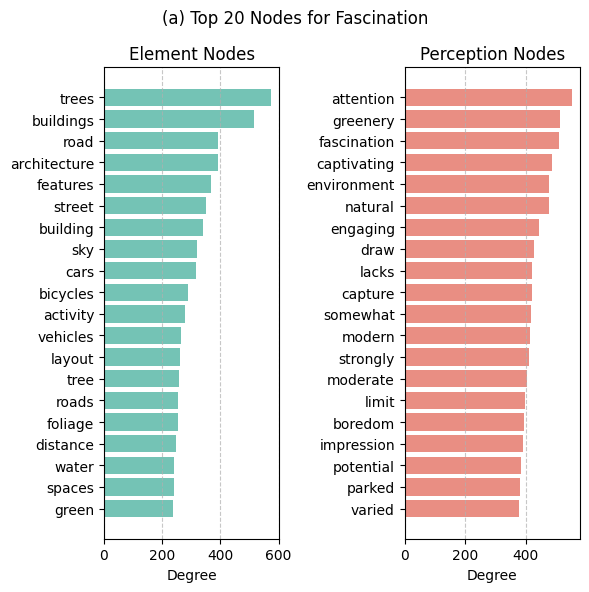

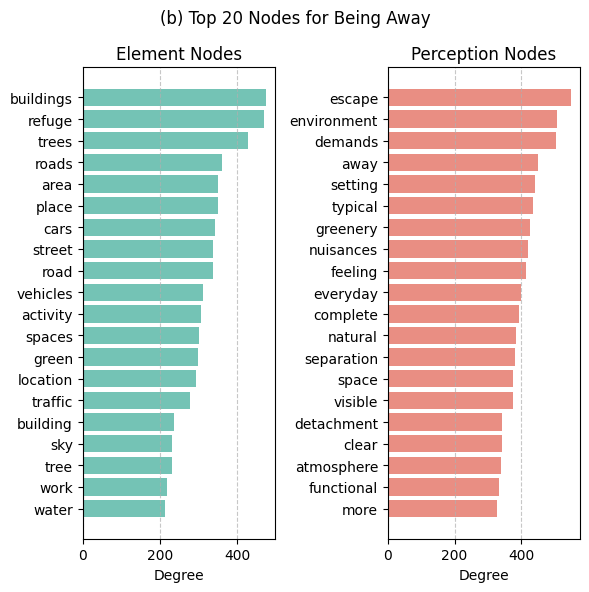

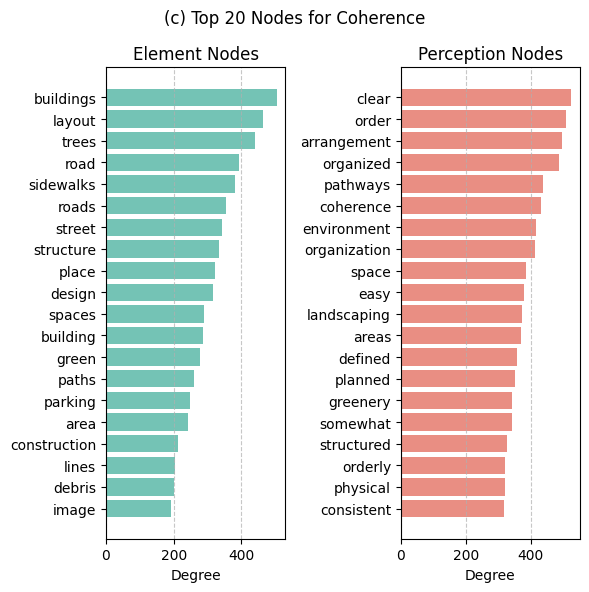

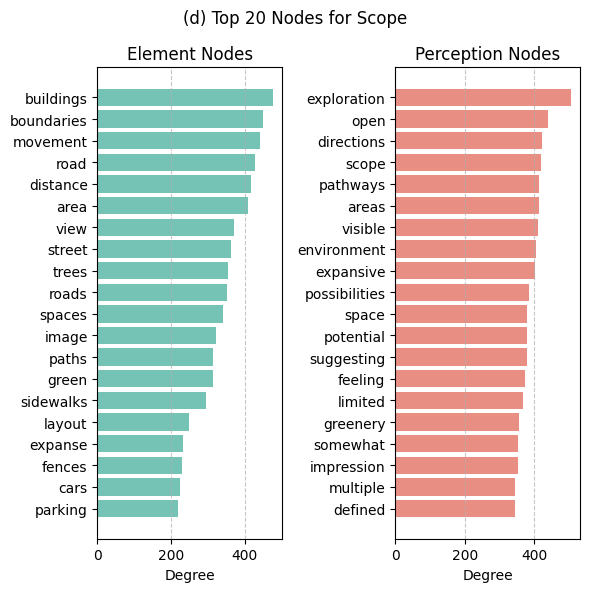

In [145]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = {
    "fascination": {
        "Objects": {
            "trees": 574, "buildings": 514, "road": 393, "architecture": 392, "features": 368,
            "street": 349, "building": 341, "sky": 321, "cars": 316, "bicycles": 288,
            "activity": 278, "vehicles": 265, "layout": 261, "tree": 259, "roads": 256,
            "foliage": 254, "distance": 248, "water": 241, "spaces": 239, "green": 237
        },
        "Descriptors": {
            "attention": 551, "greenery": 513, "fascination": 509, "captivating": 487, "environment": 476,
            "natural": 476, "engaging": 444, "draw": 428, "lacks": 420, "capture": 420,
            "somewhat": 418, "modern": 412, "strongly": 409, "moderate": 404, "limit": 397,
            "boredom": 393, "impression": 390, "potential": 385, "parked": 381, "varied": 377
        }
    },
    "being_away": {
        "Objects": {
            "buildings": 473, "refuge": 468, "trees": 427, "roads": 360, "area": 351,
            "place": 351, "cars": 342, "street": 337, "road": 336, "vehicles": 311,
            "activity": 306, "spaces": 301, "green": 298, "location": 293, "traffic": 277,
            "building": 237, "sky": 231, "tree": 230, "work": 219, "water": 213
        },
        "Descriptors": {
            "escape": 549, "environment": 508, "demands": 503, "away": 450, "setting": 440,
            "typical": 434, "greenery": 427, "nuisances": 419, "feeling": 414, "everyday": 398,
            "complete": 393, "natural": 384, "separation": 380, "space": 374, "visible": 374,
            "detachment": 343, "clear": 341, "atmosphere": 338, "functional": 334, "more": 327
        }
    },
    "coherence": {
        "Objects": {
            "buildings": 504, "layout": 465, "trees": 440, "road": 392, "sidewalks": 382,
            "roads": 353, "street": 344, "structure": 333, "place": 322, "design": 317,
            "spaces": 290, "building": 286, "green": 279, "paths": 261, "parking": 249,
            "area": 241, "construction": 213, "lines": 203, "debris": 201, "image": 193
        },
        "Descriptors": {
            "clear": 526, "order": 508, "arrangement": 498, "organized": 488, "pathways": 439,
            "coherence": 431, "environment": 417, "organization": 414, "space": 387, "easy": 379,
            "landscaping": 374, "areas": 369, "defined": 359, "planned": 351, "greenery": 343,
            "somewhat": 343, "structured": 326, "orderly": 322, "physical": 320, "consistent": 319
        }
    },
    "scope": {
        "Objects": {
            "buildings": 478, "boundaries": 449, "movement": 442, "road": 427, "distance": 418,
            "area": 408, "view": 371, "street": 362, "trees": 356, "roads": 352,
            "spaces": 340, "image": 321, "paths": 315, "green": 314, "sidewalks": 295,
            "layout": 249, "expanse": 234, "fences": 229, "cars": 224, "parking": 219
        },
        "Descriptors": {
            "exploration": 506, "open": 440, "directions": 422, "scope": 418, "pathways": 413,
            "areas": 413, "visible": 410, "environment": 405, "expansive": 402, "possibilities": 385,
            "space": 380, "potential": 380, "suggesting": 378, "feeling": 372, "limited": 368,
            "greenery": 355, "somewhat": 352, "impression": 352, "multiple": 345, "defined": 344
        }
    }
}

numbs = ['(a)', '(b)', '(c)', '(d)']
# Create visualizations
for i, (reason, data) in enumerate(categories.items()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
    fig.suptitle(f'{numbs[i]} Top 20 Nodes for {reason.replace("_", " ").title()}')
    
    # Objects plot
    objects = data['Objects']
    ax1.barh(list(objects.keys())[::-1], list(objects.values())[::-1], color='#74C3B5')
    ax1.set_title('Element Nodes')
    ax1.set_xlabel('Degree')
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Descriptors plot
    descriptors = data['Descriptors']
    ax2.barh(list(descriptors.keys())[::-1], list(descriptors.values())[::-1], color='#E98E83')
    ax2.set_title('Perception Nodes')
    ax2.set_xlabel('Degree')
    ax2.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f'./figure/{reason}_top_nodes_all.png', bbox_inches='tight', dpi=300)
    plt.show()

## Sematic network

In [ ]:
import os
import pandas as pd
import json
from openai import OpenAI
from tqdm import tqdm
import re
import concurrent.futures
tqdm.pandas()  # 启用 pandas 的进度条扩展

# Configure API
api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
base_url = "https://api.zetatechs.com/v1/"

client = OpenAI(api_key=api_key, base_url=base_url)

# Define analysis prompts
prompts = {
    "reason_fascination": """
    Analyze the text about Fascination of restorative quality of campus spaces. 
    Extract TRIPLETS following the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:

    "{text}"

    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_being_away": """
    Please analyze the following text about Being Away of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_coherence": """
    Please analyze the following text about Coherence of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
    
    "reason_scope": """
    Please analyze the following text about Scope of restorative quality of campus spaces based on PRS-11 questionnaire.
    Extract entities based on the "Spatial Elements → Psychological Perception → Behavioral Motivation" framework:
    
    "{text}"
    
    Extraction rules:
    1. Spatial Elements: Physical objects (e.g., plants, buildings, water features) (one word)
    2. Psychological Perception: Resulting mental states (short phrase)
    3. Behavioral Motivation: Actions triggered (short phrase)
    4. Relation Type: positive/negative/neutral based on effect

    Return EXACTLY this JSON format:
    {{
        "chains": [
            {{
                "spatial_element": "element1 (one word)",
                "psychological_perception": "perception1",
                "behavioral_motivation": "motivation1",
                "relation_type": "positive/negative/neutral"
            }},
            {{
                "spatial_element": "element2",
                ...
            }}
        ]
    }}
    """,
}

def analyze_text(text, analysis_type):
    """使用LLM分析文本并返回三元组链"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a structured data extraction assistant. Return ONLY valid JSON."},
                {"role": "user", "content": prompts[analysis_type].format(text=text)}
            ],
            response_format={"type": "json_object"},
            temperature=0.3  # 降低随机性
        )
        result = json.loads(response.choices[0].message.content)
        return result.get("chains", [])
    except Exception as e:
        print(f"分析错误: {e}")
        return []

def process_single_text(args):
    """处理单个文本的包装函数，用于并行执行"""
    idx, row, analysis_type = args
    text = row[analysis_type]
    image_id = os.path.basename(row["image_path"])
    chains = analyze_text(text, analysis_type)
    return [dict(chain, image_id=image_id) for chain in chains]

def main():
    # Create output directory
    output_dir = "./shanghai"
    os.makedirs(output_dir, exist_ok=True)
    
    # Read CSV data
    df = pd.read_csv('./shanghai/evaluation_result.csv')
    
    # 设置并行工作线程数 (根据API限制调整)
    MAX_WORKERS = 10
    
    # Process each analysis type
    analysis_types = ["reason_fascination", "reason_being_away", "reason_coherence", "reason_scope"]
    
    for analysis_type in analysis_types:
        print(f"Processing {analysis_type}...")
        all_chains = []
        
        # 准备并行任务参数
        tasks = [(idx, row, analysis_type) for idx, row in df.iterrows()]
        
        # 使用线程池并行处理文本
        with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            # 使用tqdm显示进度条
            results = list(tqdm(executor.map(process_single_text, tasks), total=len(tasks)))
        
        # 收集所有结果
        for result in results:
            all_chains.extend(result)
        
        if all_chains:
            chain_df = pd.DataFrame(all_chains)
            
            output_path = os.path.join(output_dir, f"{analysis_type}_relationships_sz.csv")
            chain_df.to_csv(output_path, index=False)
            print(f"Saved {len(chain_df)} chains to {output_path}")

    print("All analyses completed. Final results saved.")

if __name__ == "__main__":
    main()

Processing reason_fascination...


100%|██████████| 2575/2575 [12:02<00:00,  3.56it/s]


Saved 10315 chains to ./shanghai\reason_fascination_relationships_sz.csv
Processing reason_being_away...


100%|██████████| 2575/2575 [10:41<00:00,  4.02it/s]


Saved 8461 chains to ./shanghai\reason_being_away_relationships_sz.csv
Processing reason_coherence...


100%|██████████| 2575/2575 [12:32<00:00,  3.42it/s]


Saved 10752 chains to ./shanghai\reason_coherence_relationships_sz.csv
Processing reason_scope...


100%|██████████| 2575/2575 [11:17<00:00,  3.80it/s]

Saved 9476 chains to ./shanghai\reason_scope_relationships_sz.csv
All analyses completed. Final results saved.


In [ ]:
import pandas as pd
from collections import defaultdict
import numpy as np
import os
import json
from openai import OpenAI
from tqdm import tqdm
import re
import concurrent.futures
import time
from functools import partial

tqdm.pandas()  # 启用 pandas 的进度条扩展

# 设置OpenAI API key
api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
base_url = "https://api.zetatechs.com/v1/"

client = OpenAI(api_key=api_key, base_url=base_url)

def get_similar_meanings_batch(texts_batch, column_name):
    """使用GPT模型找出语义相似的表达并给出标准表达，处理一批文本"""
    
    texts_batch = [str(t) for t in texts_batch if pd.notna(t)]
    
    prompt = f"""Below are several different expressions of behavioral motivation from the {column_name} column. 
    Please identify groups of similar meanings and provide one standard expression for each group.
    Only output the mapping in the format: original_text -> standardized_text
    
    Expressions:
    {', '.join(texts_batch)}
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        
        # 解析返回的映射关系
        mappings = {}
        for line in response.choices[0].message.content.strip().split('\n'):
            if '->' in line:
                original, standard = line.split('->')
                mappings[original.strip()] = standard.strip()
        
        return mappings
    
    except Exception as e:
        print(f"Error in API call: {e}")
        return {}

def process_batch(batch, column_name):
    """处理单个批次并返回映射"""
    return get_similar_meanings_batch(batch, column_name)

def chunks(lst, n):
    """将列表分成大小为n的块"""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def standardize_column(df, column_name, batch_size=100, max_workers=8):
    """标准化指定列中的相似表达，使用批处理和并行处理大量唯一值"""
    
    # 获取唯一值
    unique_values = df[column_name].unique().tolist()
    print(f"Total unique values: {len(unique_values)}")
    
    # 将唯一值分批
    batches = list(chunks(unique_values, batch_size))
    print(f"Processing {len(batches)} batches of size {batch_size}")
    
    # 用于存储所有批次的映射关系
    all_mappings = {}
    
    # 创建部分函数，固定column_name参数
    batch_processor = partial(process_batch, column_name=column_name)
    
    # 使用线程池并行处理批次
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务并创建future到batch的映射
        future_to_batch = {executor.submit(batch_processor, batch): i for i, batch in enumerate(batches)}
        
        # 使用tqdm显示进度
        for future in tqdm(concurrent.futures.as_completed(future_to_batch), total=len(batches), desc="Processing batches"):
            batch_idx = future_to_batch[future]
            try:
                batch_mappings = future.result()
                all_mappings.update(batch_mappings)
                print(f"Completed batch {batch_idx+1}/{len(batches)} with {len(batch_mappings)} mappings")
            except Exception as e:
                print(f"Batch {batch_idx} generated an exception: {e}")
    
    # 因为分批处理可能导致不一致的标准化，我们再做一次合并标准化
    if len(batches) > 1:
        # 获取所有唯一的标准化值
        standard_values = list(set(all_mappings.values()))
        
        # 如果标准化的值较多，也需要分批处理
        if len(standard_values) > batch_size:
            print(f"Performing second-level standardization with {len(standard_values)} standard values")
            standard_batches = list(chunks(standard_values, batch_size))
            
            second_level_mappings = {}
            
            # 创建部分函数，固定第二级标准化的column_name参数
            std_batch_processor = partial(process_batch, column_name=f"{column_name} (standardized)")
            
            # 并行处理第二级标准化
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                future_to_std_batch = {executor.submit(std_batch_processor, std_batch): i 
                                      for i, std_batch in enumerate(standard_batches)}
                
                for future in tqdm(concurrent.futures.as_completed(future_to_std_batch), 
                                 total=len(standard_batches), desc="Second-level standardization"):
                    batch_idx = future_to_std_batch[future]
                    try:
                        batch_std_mappings = future.result()
                        second_level_mappings.update(batch_std_mappings)
                        print(f"Completed second-level batch {batch_idx+1}/{len(standard_batches)}")
                    except Exception as e:
                        print(f"Second-level batch {batch_idx} generated an exception: {e}")
            
            # 更新原始映射
            for original, standard in all_mappings.items():
                if standard in second_level_mappings:
                    all_mappings[original] = second_level_mappings[standard]
    
    # 应用映射到数据框
    df[f'{column_name}_standardized'] = df[column_name].map(
        lambda x: all_mappings.get(str(x), x) if pd.notna(x) else x
    )
    
    return df

# 读取CSV文件
df = pd.read_csv('./shanghai/reason_being_away_relationships_sz.csv')

# 对behavioral_motivation列进行标准化，设置批次大小和最大工作线程数
df = standardize_column(df, 'behavioral_motivation', batch_size=100, max_workers=8)

# 显示结果
print("Original vs Standardized behavioral_motivation:")
comparison = pd.DataFrame({
    'Original': df['behavioral_motivation'],
    'Standardized': df['behavioral_motivation_standardized']
}).drop_duplicates()
print(comparison)

# 保存结果
df.to_csv('./shanghai/stand_reason_being_away_relationships_sz.csv', index=False)


Total unique values: 2805
Processing 29 batches of size 100


Processing batches:   3%|▎         | 1/29 [00:04<02:14,  4.80s/it]

Completed batch 4/29 with 45 mappings


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ======== 1. 读取数据 ========
df = pd.read_csv("./shanghai/stand_reason_being_away_relationships_sz.csv")

spatial = 'spatial_element'
perception = 'psychological_perception'
motivation = 'behavioral_motivation_standardized'

# ======== 2. 构建完整网络图 ========
# 边频率统计
edge_freq = df.groupby([spatial, motivation]).size().to_dict()

# 建立有向图
G = nx.DiGraph()
for (u, v), freq in edge_freq.items():
    relation_type = df[(df[spatial] == u) & (df[motivation] == v)]["relation_type"].iloc[0]
    psychological_perception = df[(df[spatial] == u) & (df[motivation] == v)][perception].iloc[0]
    G.add_edge(u, v, label=psychological_perception, relation=relation_type, weight=freq)

# 额外分析：查看网络的其他特性
def analyze_graph(G):
    # 基本网络指标
    analysis = {
        'nodes': len(G.nodes()),
        'edges': len(G.edges()),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / len(G),
        'top_nodes_by_degree': sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
    }
    
    # 统计边的关系类型比例
    edge_types = {'positive': 0, 'negative': 0, 'neutral': 0}
    total_edges = len(G.edges())
    
    for u, v, data in G.edges(data=True):
        relation = data['relation']
        if relation in edge_types:
            edge_types[relation] += 1
            
    # 计算比例
    edge_type_ratios = {k: v/total_edges for k, v in edge_types.items()}
    analysis['edge_type_ratios'] = edge_type_ratios
    
    return analysis

analysis = analyze_graph(G)
print("\nNetwork Analysis:")
for metric, value in analysis.items():
    if metric == 'edge_type_ratios':
        print("\nEdge type ratios:")
        for type_name, ratio in value.items():
            print(f"{type_name}: {ratio:.1%}")
    elif metric == 'top_nodes_by_degree':
        print("\nTop nodes by degree:")
        for node, degree in value:
            print(f"{node}: {degree}")
    else:
        print(f"{metric}: {value}")


Network Analysis:
nodes: 1481
edges: 4679
density: 0.0021346971549537383
avg_degree: 6.318703578663065

Top nodes by degree:
buildings: 291
traffic: 253
trees: 234
greenery: 228
vehicles: 226
sky: 167
architecture: 147
road: 142
infrastructure: 120
construction: 115

Edge type ratios:
positive: 38.0%
negative: 47.1%
neutral: 15.0%


## Figure 9

nodes: 20
edges: 96
density: 0.25263157894736843
avg_degree: 9.6
top_nodes_by_degree: [('avoidance', 10), ('boredom', 10), ('disengagement', 10), ('disinterest', 10), ('exploration', 10), ('lack of engagement', 10), ('limited engagement', 10), ('buildings', 10), ('greenery', 10), ('road', 10)]

Edge type ratios:
positive: 22.9%
negative: 68.8%
neutral: 8.3%


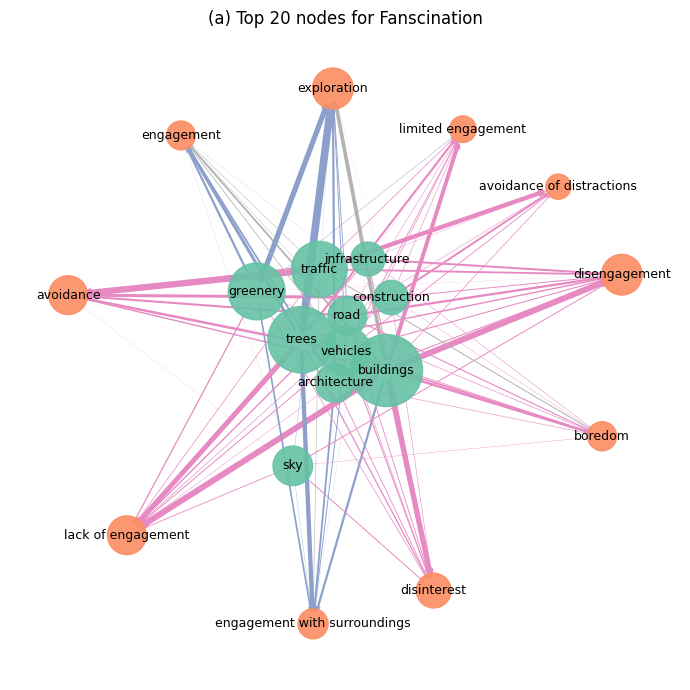

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ======== 1. 读取数据 ========
df = pd.read_csv("./shanghai/stand_reason_fascination_relationships_sz.csv")
# df = df[df['relation_type']== 'negative']  # 只保留正向关系
# df = df[df['behavioral_motivation_standardized']!= 'none']  # 只保留正向关系

spatial = 'spatial_element'
perception = 'psychological_perception'
motivation = 'behavioral_motivation_standardized'

# ======== 2. 统计 element 和 perception 频率 ========
element_counts = df[spatial].value_counts().reset_index()
element_counts.columns = ["node", "count"]

behavioral_counts = df[motivation].value_counts().reset_index()
behavioral_counts.columns = ["node", "count"]

# ======== 3. 取前 10 个 element & perception 节点 ========
top_elements = element_counts.head(10)["node"]
top_behavioral = behavioral_counts.head(10)["node"]

# 只保留这些 element & perception 对应的链路
df = df[df[spatial].isin(top_elements) & df[motivation].isin(top_behavioral)]

# ======== 4. 构建节点频率字典（element + perception） ========
freq_dict = pd.concat([element_counts, behavioral_counts], ignore_index=True) \
              .groupby("node")["count"].sum().to_dict()

# ======== 5. 边频率统计 ========
edge_freq = df.groupby([spatial, motivation]).size().to_dict()

## behavioral_motivation, psychological_perception
# ======== 6. 建立有向图，并保存 relation_type & 频率 ========
G = nx.DiGraph()
for (u, v), freq in edge_freq.items():
    relation_type = df[(df[spatial] == u) & (df[motivation] == v)]["relation_type"].iloc[0]
    psychological_perception = df[(df[spatial] == u) & (df[motivation] == v)][perception].iloc[0]
    G.add_edge(u, v, label=psychological_perception, relation=relation_type, weight=freq)

def analyze_graph(G):
    # 基本网络指标
    analysis = {
        'nodes': len(G.nodes()),
        'edges': len(G.edges()),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / len(G),
        'top_nodes_by_degree': sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
    }
    
    # 统计边的关系类型比例
    edge_types = {'positive': 0, 'negative': 0, 'neutral': 0}
    total_edges = len(G.edges())
    
    for u, v, data in G.edges(data=True):
        relation = data['relation']
        if relation in edge_types:
            edge_types[relation] += 1
            
    # 计算比例
    edge_type_ratios = {k: v/total_edges for k, v in edge_types.items()}
    analysis['edge_type_ratios'] = edge_type_ratios
    
    return analysis

analysis = analyze_graph(G)
for metric, value in analysis.items():
    if metric == 'edge_type_ratios':
        print("\nEdge type ratios:")
        for type_name, ratio in value.items():
            print(f"{type_name}: {ratio:.1%}")
    else:
        print(f"{metric}: {value}")

# ======== 7. 手动左右布局 ========
elements = sorted(top_elements, key=lambda x: freq_dict.get(x, 0), reverse=True)
behavioral = sorted(top_behavioral, key=lambda x: freq_dict.get(x, 0), reverse=True)

pos = nx.spring_layout(G, k=6, iterations=100, seed=123)  # 使用 spring 布局

# ======== 8. 节点大小（频率 * 缩放系数） ========
node_sizes = [freq_dict.get(node, 1) * 2 for node in G.nodes()]

# ======== 9. 边颜色映射（positive=绿色，negative=红色，其它灰色） & 边宽度 ========
edge_colors = []
edge_widths = []
for u, v in G.edges():
    relation = G[u][v].get("relation", "").lower()
    if relation == "positive":
        edge_colors.append("#8DA0CB")
    elif relation == "negative":
        edge_colors.append("#E78AC3")
    else:
        edge_colors.append("#B3B3B3")
    edge_widths.append(G[u][v]["weight"]*0.05)  # 按频率作为宽度

# ======== 10. 绘图 ========
plt.figure(figsize=(7, 7))
node_colors = ["#66C2A5" if n in elements else "#FC8D62" for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9)
nx.draw_networkx_edges(
    G, pos,
    # arrows=None,  # 不显示箭头
    arrowstyle="->", arrowsize=5,
    edge_color=edge_colors,
    width=edge_widths
)

# 边标签
edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.axis("off")
plt.title("(a) Top 20 nodes for Fanscination", fontsize=12)
plt.tight_layout()
plt.savefig('./figure/Fanscination_top_nodes_sz.png', bbox_inches='tight', dpi=300)
plt.show()

## Figure 10

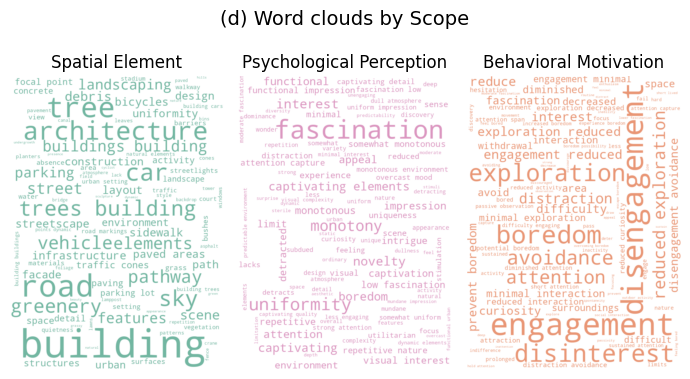

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

# 创建示例数据
data = pd.read_csv("./spatial_analysis_results/reason_fascination_relationships_3.csv")
data = data[data['relation_type'] == 'negative']  # 只保留正向关系

# 为每个类别定义停用词
#fascination
category_stopwords = {
    'spatial_element': set(['']),  # 空间元素中要去除的词
    'behavioral_motivation': set(['limited', 'lack', 'limit']),  # 行为动机中要去除的词
    'psychological_perception': set(['lack', 'engagement', 'limited'])  # 心理感知中要去除的词
}
##being away
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['presence', 'suggest', 'indicate']),  # 行为动机中要去除的词
#     'psychological_perception': set(['lack', 'feeling', 'sense', 'escape', 'limited'])  # 心理感知中要去除的词
# }

# ##coherence
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['create', 'area','space','creates']),  # 行为动机中要去除的词
#     'psychological_perception': set(['lack'])  # 心理感知中要去除的词
# }

# ##coherence
# category_stopwords = {
#     'spatial_element': set(['']),  # 空间元素中要去除的词
#     'behavioral_motivation': set(['']),  # 行为动机中要去除的词
#     'psychological_perception': set(['feeling', 'sense'])  # 心理感知中要去除的词
# }


# 创建图形和子图
fig, axes = plt.subplots(1, 3, figsize=(7, 4))
fig.suptitle('(d) Word clouds by Scope', fontsize=14)

# 设置颜色
colors = ['#72B6A1', '#DB96C0','#E99675',]

# 为每个类别生成词云
for idx, (category, words) in enumerate(data.items()):
    if idx < 3:
        # 将列表中的词转换为适合词云的文本格式
        text = ' '.join(words) + ' ' + ' '.join(words)  # 重复文本以增加词频

        # 使用该类别的特定停用词
        stopwords = STOPWORDS.union(category_stopwords[category])
        
        # 创建词云
        wordcloud = WordCloud(
            width=800,
            height=1100,
            background_color='white',
            max_words=100,
            color_func=lambda *args, **kwargs: colors[idx],  # 使用指定颜色
            stopwords=stopwords,
            random_state=42
        ).generate(text)
        
        # 显示词云
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(category.replace('_', ' ').title())  # 标题也使用相应颜色

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./figure/scope_wordclouds.png', bbox_inches='tight', dpi=300)
plt.show()

## Figure 5b

In [8]:
import pandas as pd
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran_Local

# 读取CSV数据
df = pd.read_csv(r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\image_paths - 副本.csv')

# 构建空间权重矩阵（基于距离）
coords = list(zip(df['lon'], df['lat']))
w = DistanceBand(coords, threshold=0.1, binary=False)  # 设置阈值为0.5度
w.transform = 'r'  # 行标准化

# 计算局部莫兰指数
local_moran = Moran_Local(df['score'], w)

# 将结果添加到原始数据框
df['local_moran_i'] = local_moran.Is  # 局部莫兰I值
df['local_moran_p'] = local_moran.p_sim  # P值
df['local_moran_quad'] = local_moran.q  # 象限分类 (1=HH, 2=LH, 3=LL, 4=HL)

# 添加象限类别的文字描述
quad_labels = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
df['local_moran_category'] = [quad_labels.get(q, 'Not significant') if p <= 0.05 else 'Not significant' 
                          for q, p in zip(local_moran.q, local_moran.p_sim)]

# 保存结果到CSV
output_path = r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\local_moran_results.csv'
df.to_csv(output_path, index=False)

print(f"局部莫兰指数计算完成，结果已保存至: {output_path}")

d:\miniconda3\envs\torch\lib\site-packages\scipy\sparse\_data.py:132: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


局部莫兰指数计算完成，结果已保存至: D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\local_moran_results.csv


## Figure 6

C:\Users\浩然\AppData\Local\Temp\ipykernel_37300\1083404995.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


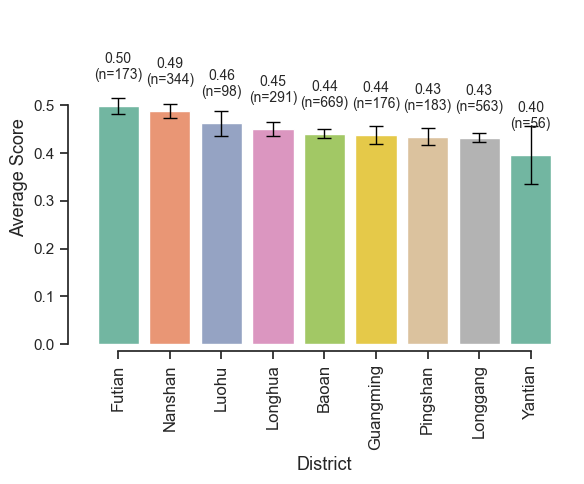

区域平均分柱状图已保存至: D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\district_average_scores.png
区域统计数据已保存至: D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\district_stats.csv


In [93]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 读取CSV数据
df = pd.read_csv(r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\image_paths - 副本.csv')

# 读取深圳区域GeoJSON文件
# 请替换为您的GeoJSON文件实际路径
geojson_path = r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\shenzhen.json'
gdf = gpd.read_file(geojson_path)

# 确保CSV数据中有经纬度信息
if 'lon' in df.columns and 'lat' in df.columns:
    # 将CSV数据转换为GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.lon, df.lat),
        crs="EPSG:4326"  # WGS84坐标系
    )
    
    # 确保两个GeoDataFrame使用相同的坐标参考系统
    if gdf.crs != points_gdf.crs:
        points_gdf = points_gdf.to_crs(gdf.crs)
    
    # 空间连接以确定每个点所在的区
    joined = gpd.sjoin(points_gdf, gdf, how="left", predicate="within")
    
    # 假设区域名称列为'name'，根据实际GeoJSON文件调整
    # 获取区域名称列（通常为'name'或'NAME'等）
    district_col = [col for col in gdf.columns if col.lower() in ['name', 'district', 'district_name']][0]
    
    # 计算每个区的平均值和标准误差
    district_stats = joined.groupby(f'index_right')[['score']].agg({
        'score': ['mean', 'count', 'std']
    }).reset_index()
    
    district_stats.columns = ['district_id', 'mean', 'count', 'std']
    
    # 计算标准误差
    district_stats['se'] = district_stats['std'] / np.sqrt(district_stats['count'])
    
    # 计算95%置信区间
    district_stats['ci95'] = district_stats['se'] * stats.t.ppf(1-0.025, district_stats['count']-1)
    
    # 获取实际区域名称
    district_names = gdf.iloc[district_stats['district_id']]['name'].values
    district_stats['district_name'] = district_names
    
    # 按平均分排序
    district_stats = district_stats.sort_values('mean', ascending=False)
    
    # 绘制柱状图带误差棒
    plt.figure(figsize=(6, 5))
    sns.set_style("ticks")
    
    # 创建柱状图
    ax = sns.barplot(
        x='district_name', 
        y='mean', 
        data=district_stats,
        palette="Set2"
        # color='lightgray'
    )
    
    # 添加误差棒（95%置信区间）
    plt.errorbar(
        x=np.arange(len(district_stats)), 
        y=district_stats['mean'],
        yerr=district_stats['ci95'],
        fmt='none',
        capsize=5,
        ecolor='black',
        elinewidth=1,
        capthick=1
    )
    
    # 设置图表标题和轴标签
    # plt.title('Average Score by District in Shenzhen with 95% Confidence Intervals', fontsize=16)
    sns.despine(offset=5, trim=True)
    plt.xlabel('District', fontsize=13)
    plt.ylabel('Average Score', fontsize=13)
    plt.xticks(rotation = 90, fontsize=12)
    plt.ylim(0, 0.7)

    
    # 在每个柱上添加均值和样本数量标签
    for i, p in enumerate(ax.patches):
        count = district_stats.iloc[i]['count']
        mean = district_stats.iloc[i]['mean']
        ax.annotate(f'{mean:.2f}\n(n={count})', 
                   (p.get_x() + p.get_width() / 2., p.get_height()+0.05), 
                   ha = 'center', va = 'bottom',
                   fontsize=10,
                   rotation=0)
    
    plt.tight_layout()
    
    # 保存图像
    output_path = r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\district_average_scores.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    # 显示图像
    plt.show()
    
    print(f"区域平均分柱状图已保存至: {output_path}")
    
    # 将统计结果保存到CSV
    stats_output_path = r'D:\A_Research\A_doing_research\20250804_LLM_campus_restoration\shanghai\district_stats.csv'
    district_stats.to_csv(stats_output_path, index=False)
    print(f"区域统计数据已保存至: {stats_output_path}")
    
else:
    print("错误: CSV文件中缺少经度(lon)或纬度(lat)列")
